# &AElig;co
# Visualization Example 

✈️♻️

This code is part of the Master's Thesis "Streamlined Life Cycle Assessment Method for Aircraft Eco-Design", by Giácomo Parolin.

``Please enter the following information:``

In [1]:
import os
os.chdir("C:/Users/giparoli/Documents/Projetos/AEco")

path = '.\\Outputs\\Iris_outputs'  # LCA results file path
#path = '.\\Outputs\\Antera_spray_outputs'  # LCA results file path

In [2]:
from Tools_Iris import *
import seaborn as sns
pal = sns.color_palette("Paired", 16)

Loading LCA results saved in the `NetCDF` file.

In [3]:
no_pest_phases = {'Development': ['Office','Infrastructure','Capital','Prototypes','Certification'],
                'Manufacturing': ['Materials','Factory','Logistics','Sustaining'],
                'Operation': ['Flight','Maintenance','Fuel'],
                'End-of-Life': ['Recycling','Landfill','Incineration']
                }


In [4]:
aeco_pest = LCIA.load(path, chunks={}, LCI=False, CTV=True)
aeco_no_pest = LCIA.load(path, chunks={}, LCI=False, CTV=False, no_pest=True, phases=no_pest_phases)
#bravo = LCIA.load(bravo_path, chunks={}, LCI=False, CTV=False)
#echo = LCIA.load(echo_path, chunks={}, LCI=False, CTV=False)

Values extracted from `calc` notebook

In [5]:
ha_fleet = 2.40031708e+09
ha_life = 5690865.44756203

Climate change data for one aircraft.
For reference, this is ~666 kt CO2eq for an Airbus A320

In [6]:
CC_mean = aeco_no_pest.mean(by="sum").loc[{"Categories":"CC"}].compute()
CC_life = CC_mean.data * ha_life * 1e-3
print(f"One aircraft emits {CC_life} tonnes of CO2eq.")
CC_pct = CC_life / (665911.2901699999) * 100
print(f"This is equivalent to {CC_pct} % of the emissions of an Airbus A320.")

One aircraft emits 12009.125388462317 tonnes of CO2eq.
This is equivalent to 1.8034121910437226 % of the emissions of an Airbus A320.


In [7]:
CC_mean = aeco_pest.mean(by="sum").loc[{"Categories":"CC"}].compute()
CC_life = CC_mean.data * ha_life * 1e-3
print(f"One aircraft emits {CC_life} tonnes of CO2eq.")
CC_pct = CC_life / (665911.2901699999) * 100
print(f"This is equivalent to {CC_pct} % of the emissions of an Airbus A320.")

One aircraft emits 334841.91150245955 tonnes of CO2eq.
This is equivalent to 50.28326091557601 % of the emissions of an Airbus A320.


## Cálculo de CC cradle to gate

In [43]:
CC_Gate = airbus.mean('MP', 'phase').sel(Categories='CC')['Development'] + airbus.mean('MP', 'phase').sel(Categories='CC')['Manufacturing']

In [40]:
CC_Grave = airbus.mean('MP', 'phase').sel(Categories='CC')['Development']+airbus.mean('MP', 'phase').sel(Categories='CC')['Manufacturing']+airbus.mean('MP', 'phase').sel(Categories='CC')['Operation']+airbus.mean('MP', 'phase').sel(Categories='CC')['End-of-Life']

In [53]:
CC_Grave.load().data

array(0.11201315)

In [54]:
CC_Gate.load().data

array(0.00138788)

Porcentagem Cradle-to-Gate em relação ao total (Cradle-to-Grave)

In [66]:
pct_gate2grave = (CC_Gate/CC_Grave).data*100
pct_gate2grave

1.239030853101566

In [48]:
pkm_fleet = 3.00345742e+13
pkm_life = 5.9087071e+09

In [61]:
CC_Gate_life = CC_Gate * pkm_life

Emissões Cradle-to-Gate de uma aeronave em sua vida

In [65]:
CC_Gate_life.data/1000

8200.561766951978

Emissões Cradle-to-Grave de uma aeronave em sua vida

In [69]:
CC_Gate_life.data/1000 / (pct_gate2grave/100)

661852.9107991277

## Figures

The distributions of the results, considering all the iterations, are plotted for each impact category using the `LCIA.dist()` method.

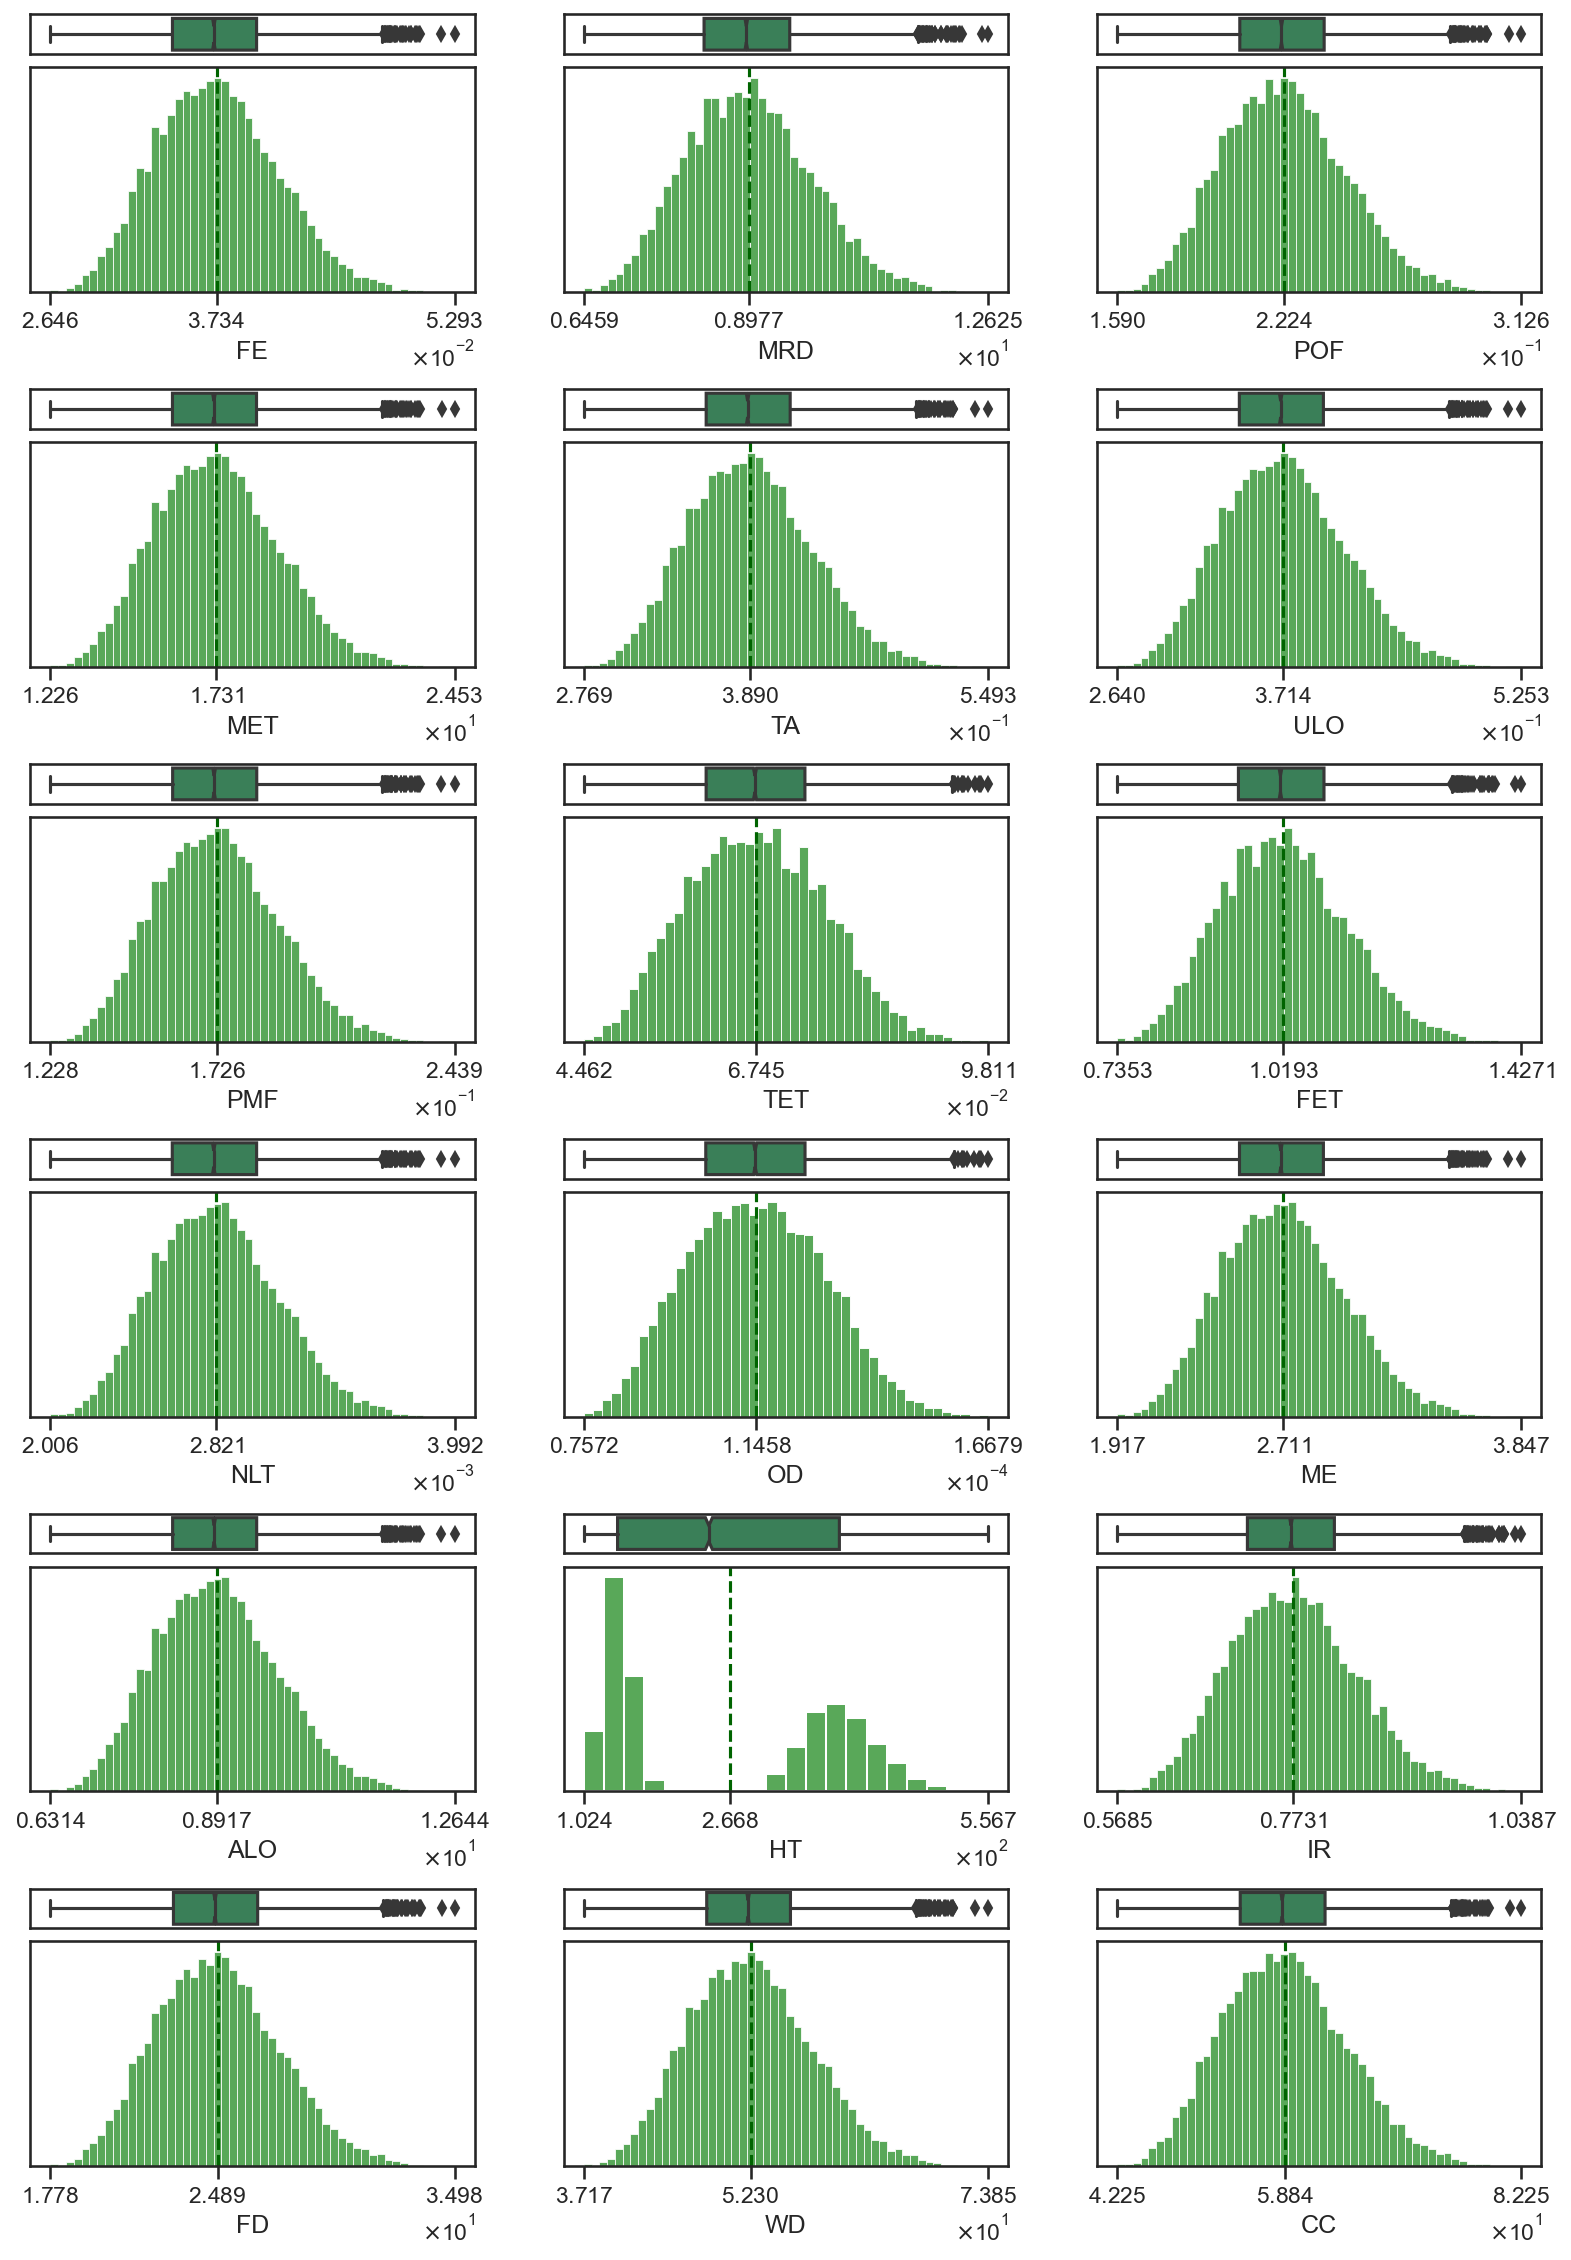

In [8]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

aeco_pest.dist('MP', save=True)

Mean midpoint results are shown below.

In [21]:
aeco_no_pest.mean('MP', by='sum').compute()

<xarray.DataArray 'stack-ede7b25f4beefb4f1262c2ed9e85fecc' (Categories: 18)>
array([1.08337712e-04, 9.91512348e-02, 5.27216085e-03, 2.57046480e-02,
       4.83906917e-03, 3.17970090e-03, 1.87687863e-03, 6.01565343e-03,
       2.49206136e-02, 2.10941971e-05, 1.05557466e-05, 2.25601698e-04,
       2.33820098e-02, 1.25901992e+02, 9.78555775e-02, 5.92777607e-01,
       6.40100777e-01, 2.11024588e+00])
Coordinates:
  * Categories  (Categories) object 'FE' 'MRD' 'POF' 'MET' ... 'FD' 'WD' 'CC'

In [22]:
aeco_pest.mean('MP', by='sum').compute()

<xarray.DataArray 'stack-ea415b81aeaf4d34ad038d9f648a51d0' (Categories: 18)>
array([3.73408465e-02, 8.97704001e+00, 2.22383143e-01, 1.73050063e+01,
       3.88991342e-01, 3.71389458e-01, 1.72577700e-01, 6.74488836e-02,
       1.01926745e+00, 2.82140365e-03, 1.14575850e-04, 2.71115623e+00,
       8.91738258e+00, 2.66805821e+02, 7.73088721e-01, 2.48921900e+01,
       5.23034356e+01, 5.88384868e+01])
Coordinates:
  * Categories  (Categories) object 'FE' 'MRD' 'POF' 'MET' ... 'FD' 'WD' 'CC'

Next, we calculate mean midpoint impacts per life cycle phase using the `LCIA.bar()` method.

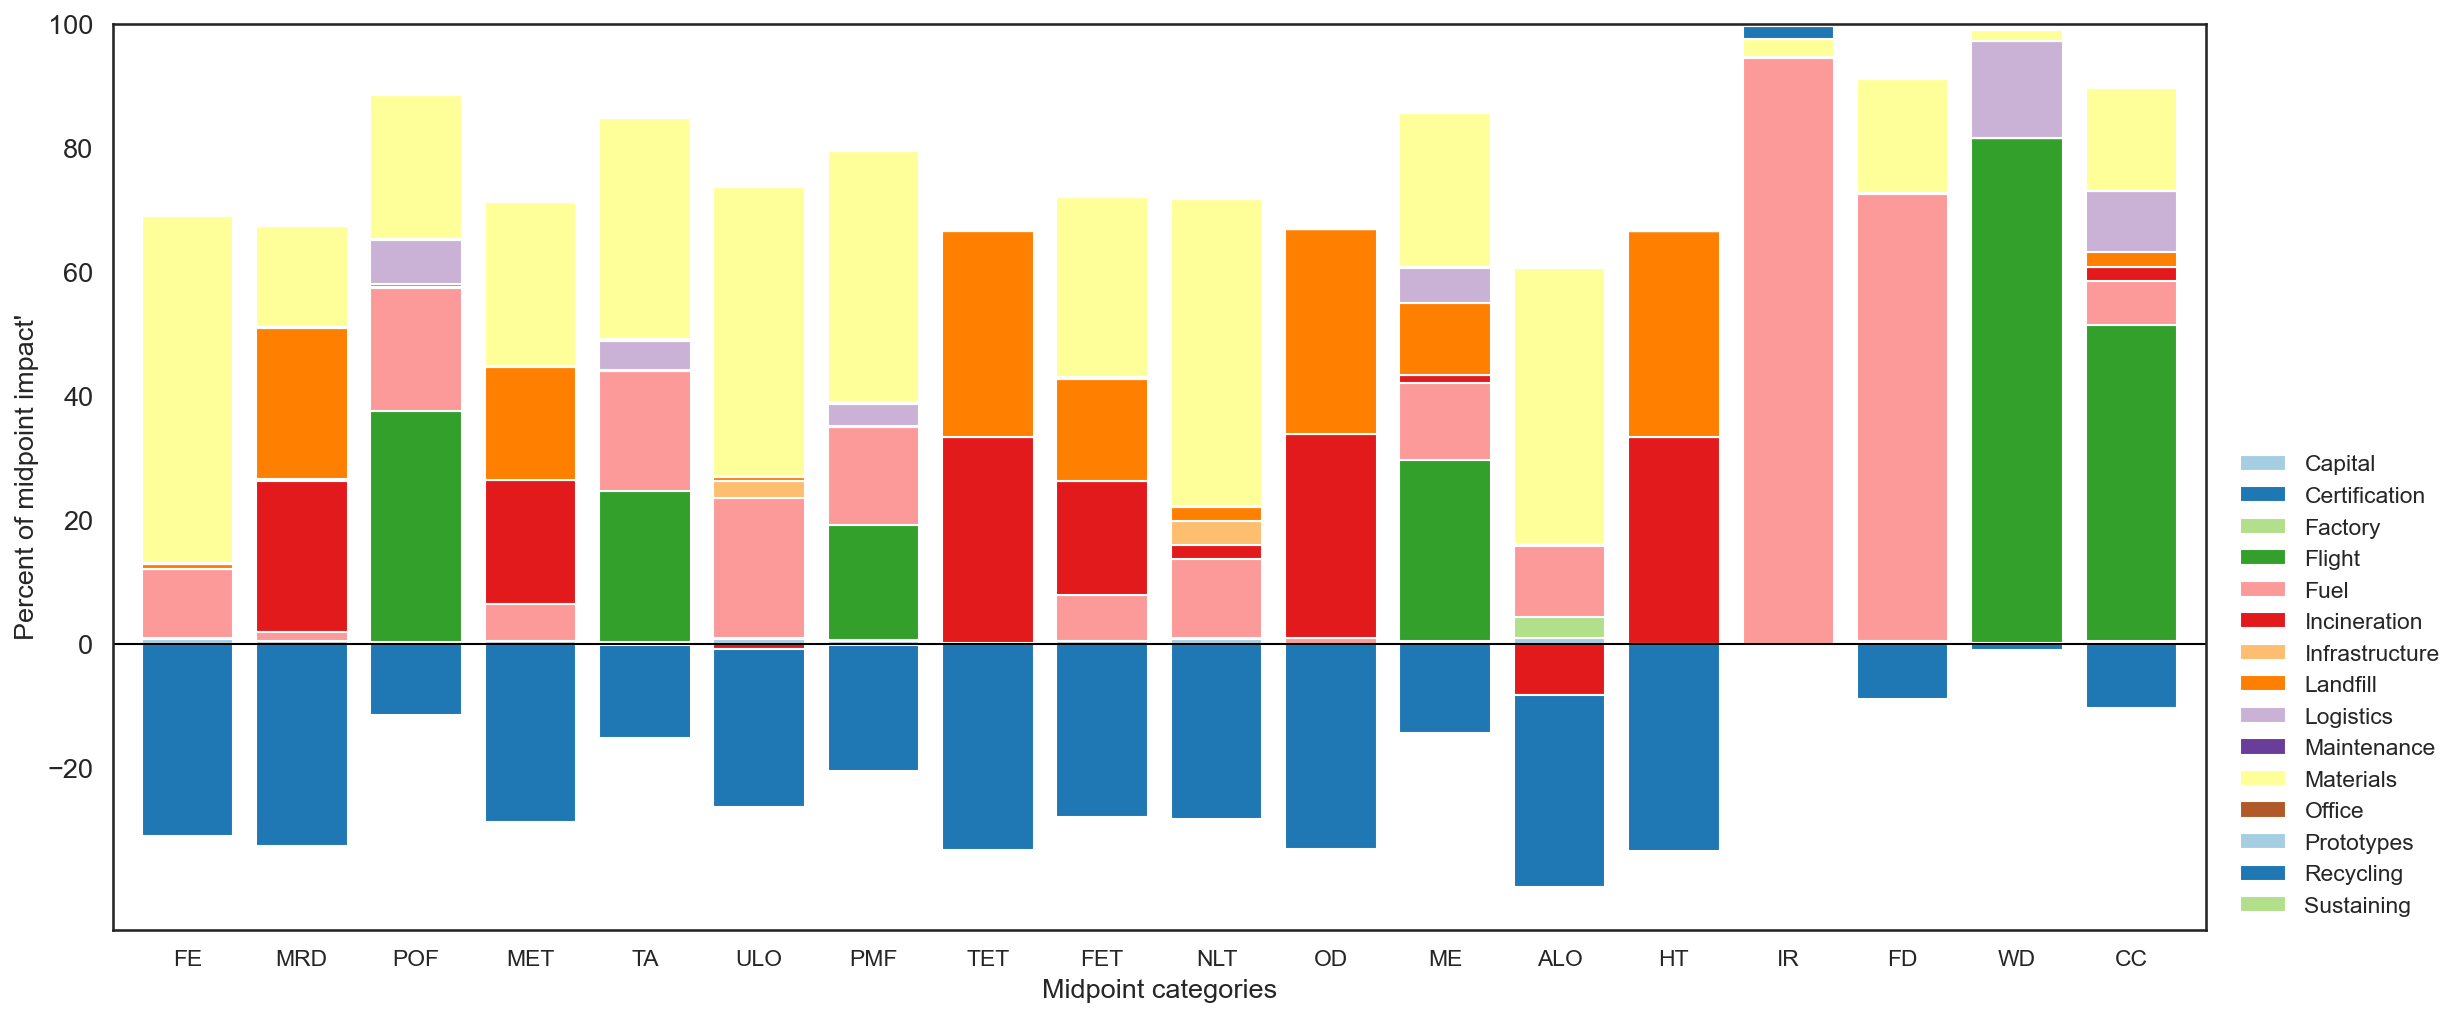

In [23]:
aeco_no_pest.bar('MP', subphase=True, save=True, palette=pal)

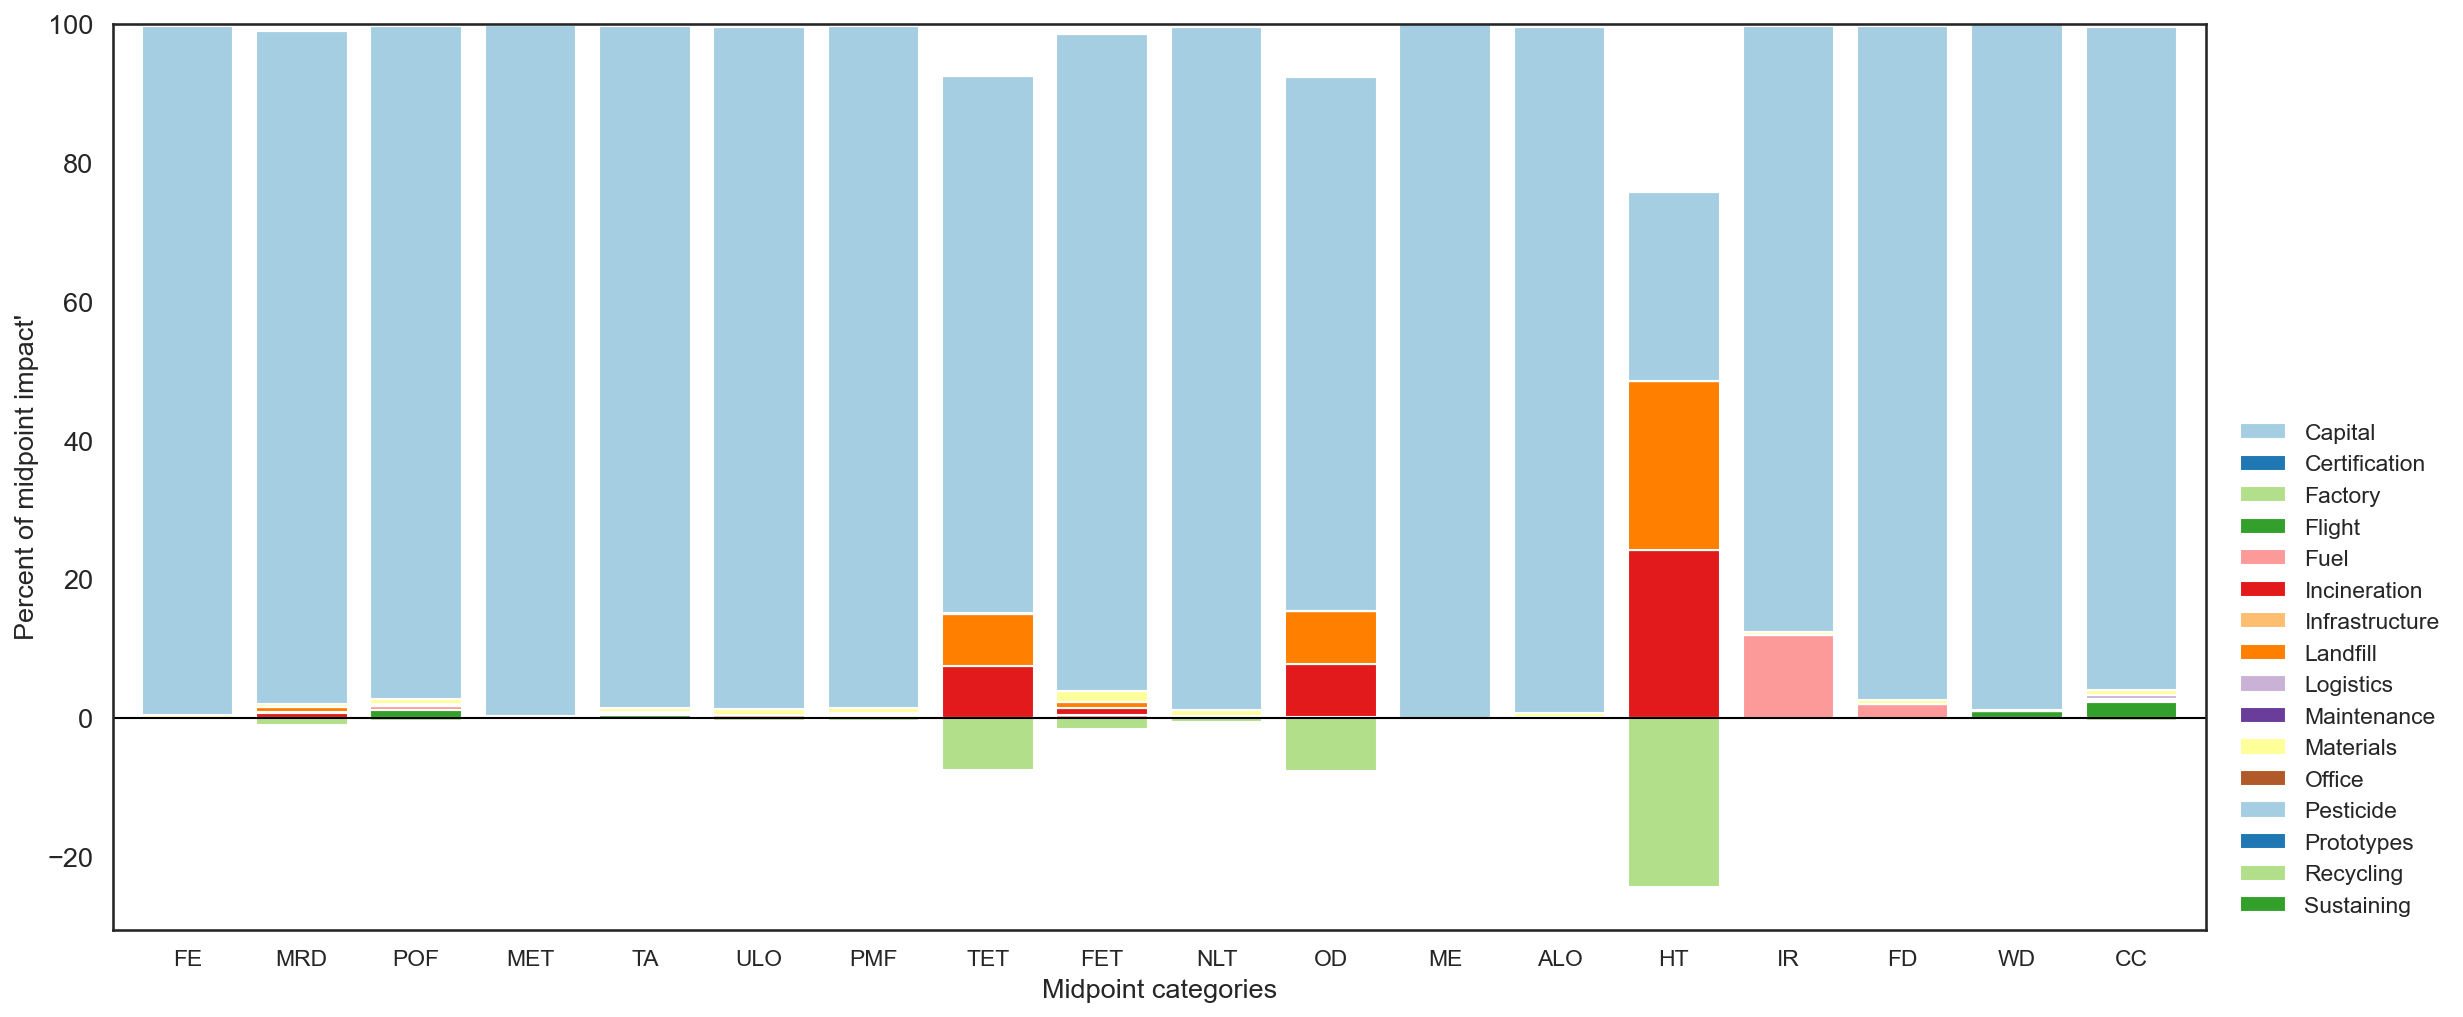

In [24]:
aeco_pest.bar('MP', subphase=True, save=True, palette=pal)

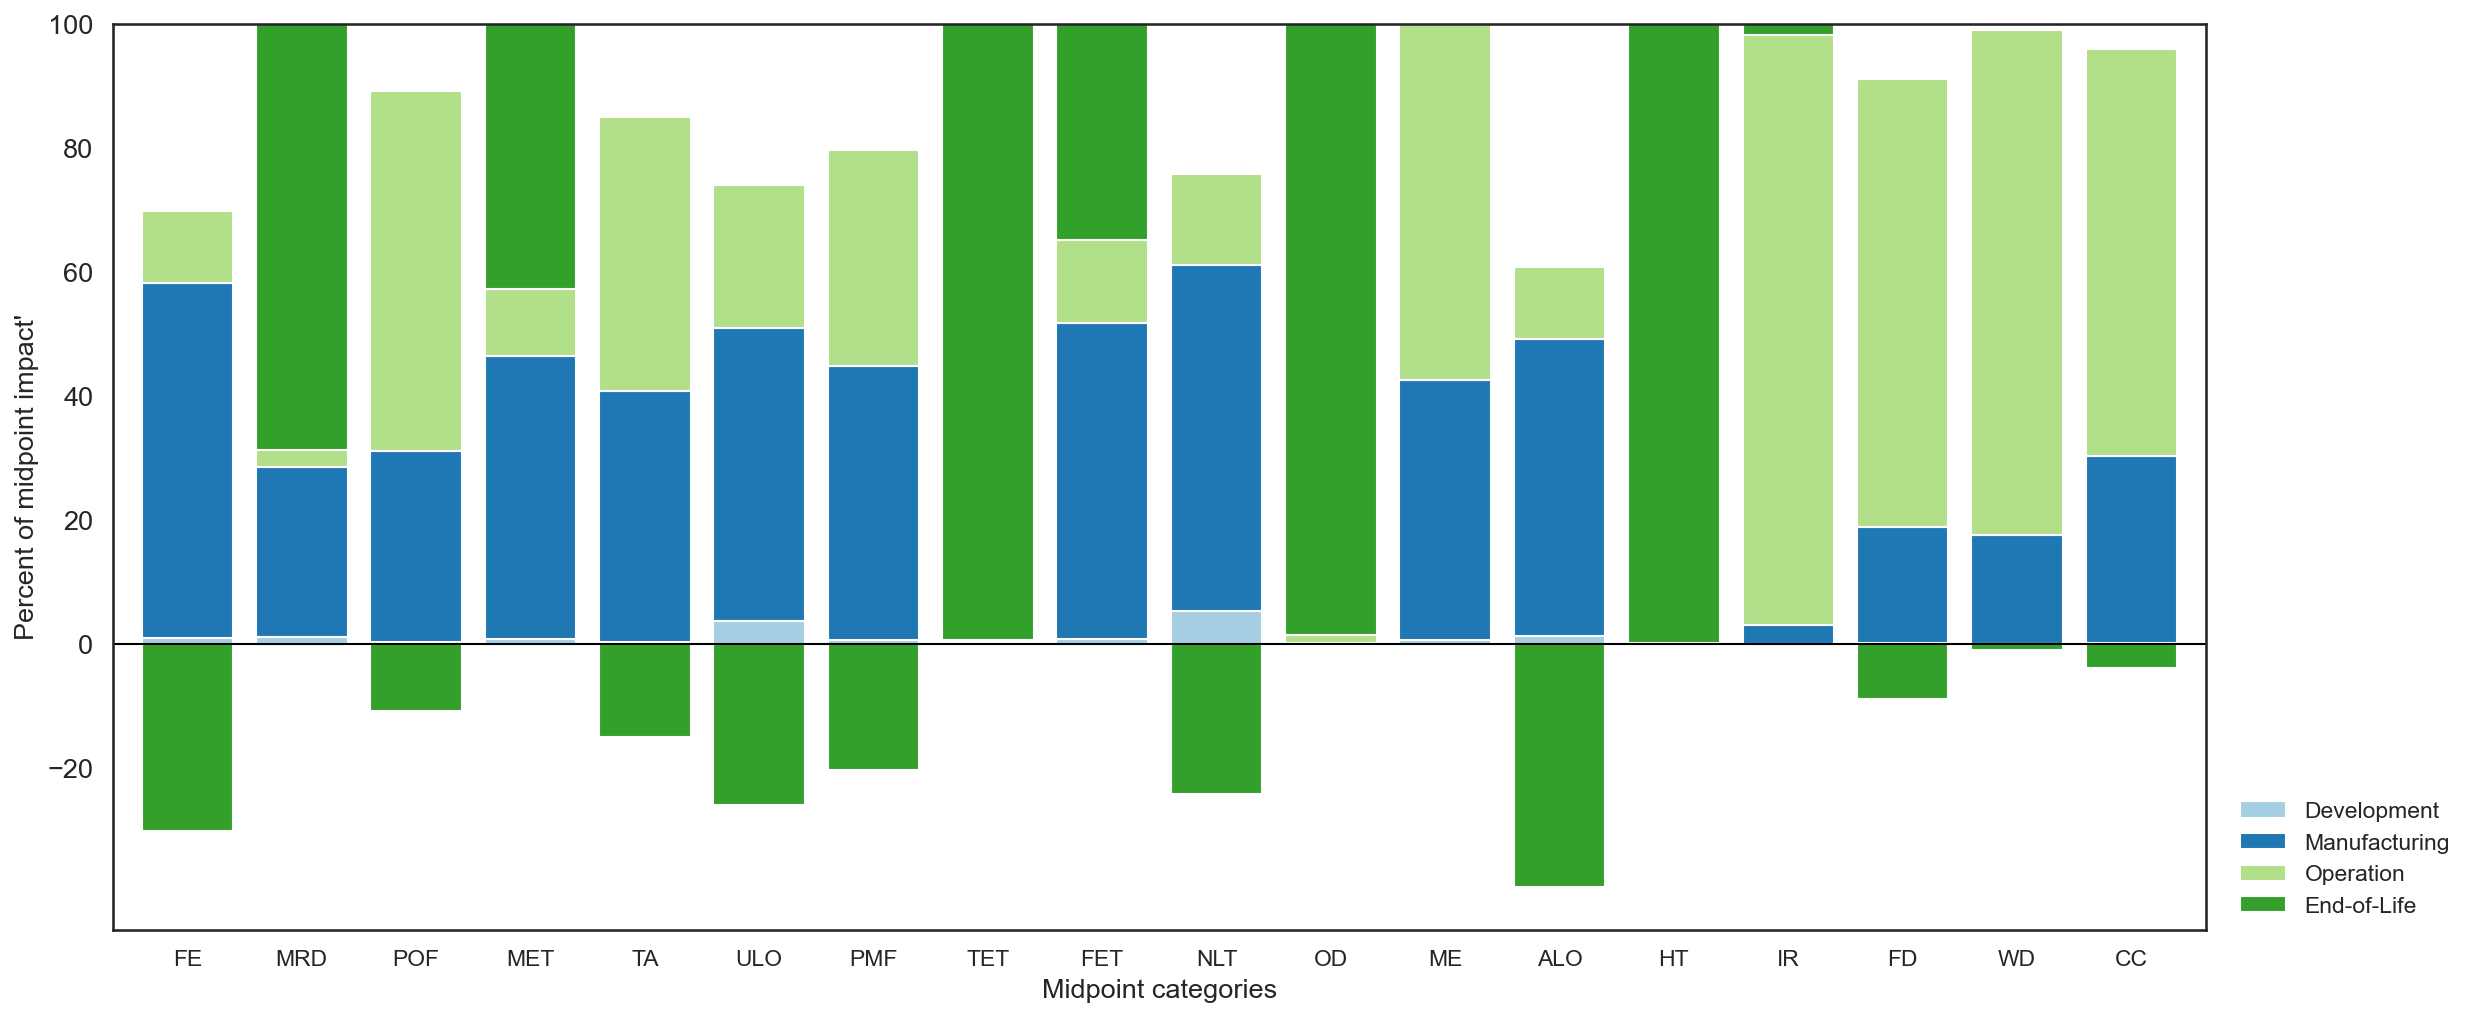

In [10]:
aeco_no_pest.bar('MP', subphase=False, save=True, palette=pal)

# Endpoint Results

The distributions of the endpoint results, considering all the iterations, are plotted for each impact category using the `LCIA.dist()` method.

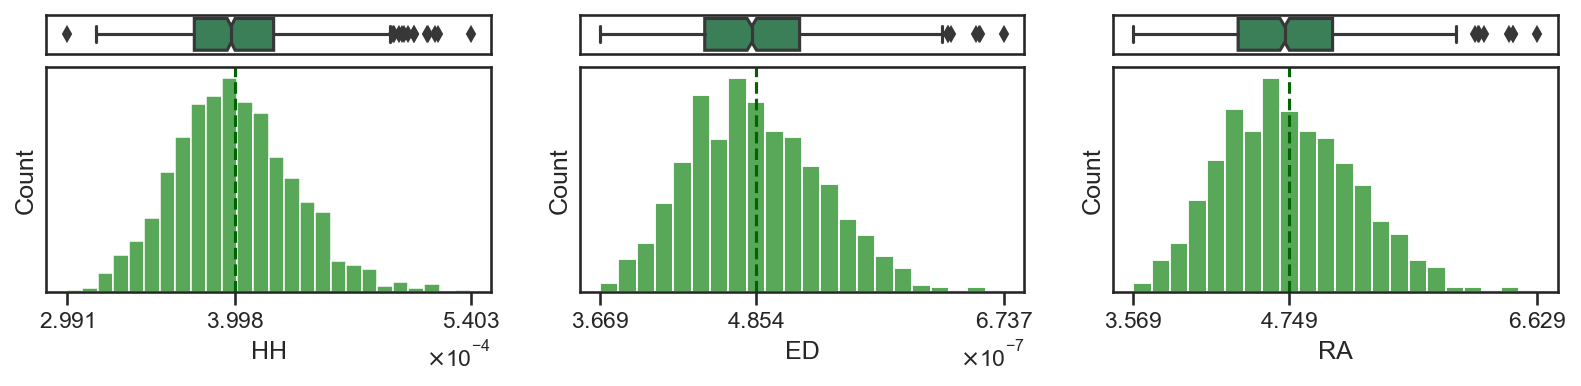

In [9]:
aeco.dist('EP', save=False)

Mean endpoint results are shown below.

In [14]:
aeco_no_pest.mean('EP', by='subphase').compute()

<xarray.Dataset>
Dimensions:         (AOP: 3)
Coordinates:
  * AOP             (AOP) object 'HH' 'ED' 'RA'
Data variables: (12/15)
    Capital         (AOP) float64 1.059e-08 2.713e-11 0.0002409
    Certification   (AOP) float64 6.402e-11 3.357e-13 0.0
    Factory         (AOP) float64 1.115e-08 5.874e-11 0.0003601
    Flight          (AOP) float64 2.044e-06 1.072e-08 0.0
    Fuel            (AOP) float64 4.243e-07 1.485e-09 0.08569
    Incineration    (AOP) float64 0.0001741 2.727e-09 0.009778
    ...              ...
    Maintenance     (AOP) float64 3.381e-09 6.934e-12 8.025e-05
    Materials       (AOP) float64 1.074e-06 3.517e-09 0.02492
    Office          (AOP) float64 6.457e-10 3.401e-12 2.085e-05
    Prototypes      (AOP) float64 1.418e-15 4.673e-18 3.304e-11
    Recycling       (AOP) float64 -0.0001746 -4.435e-09 -0.02202
    Sustaining      (AOP) float64 3.499e-19 1.843e-21 1.13e-14

Endpoint impacts per life cycle phase are plotted with the `LCIA.bar()` method.

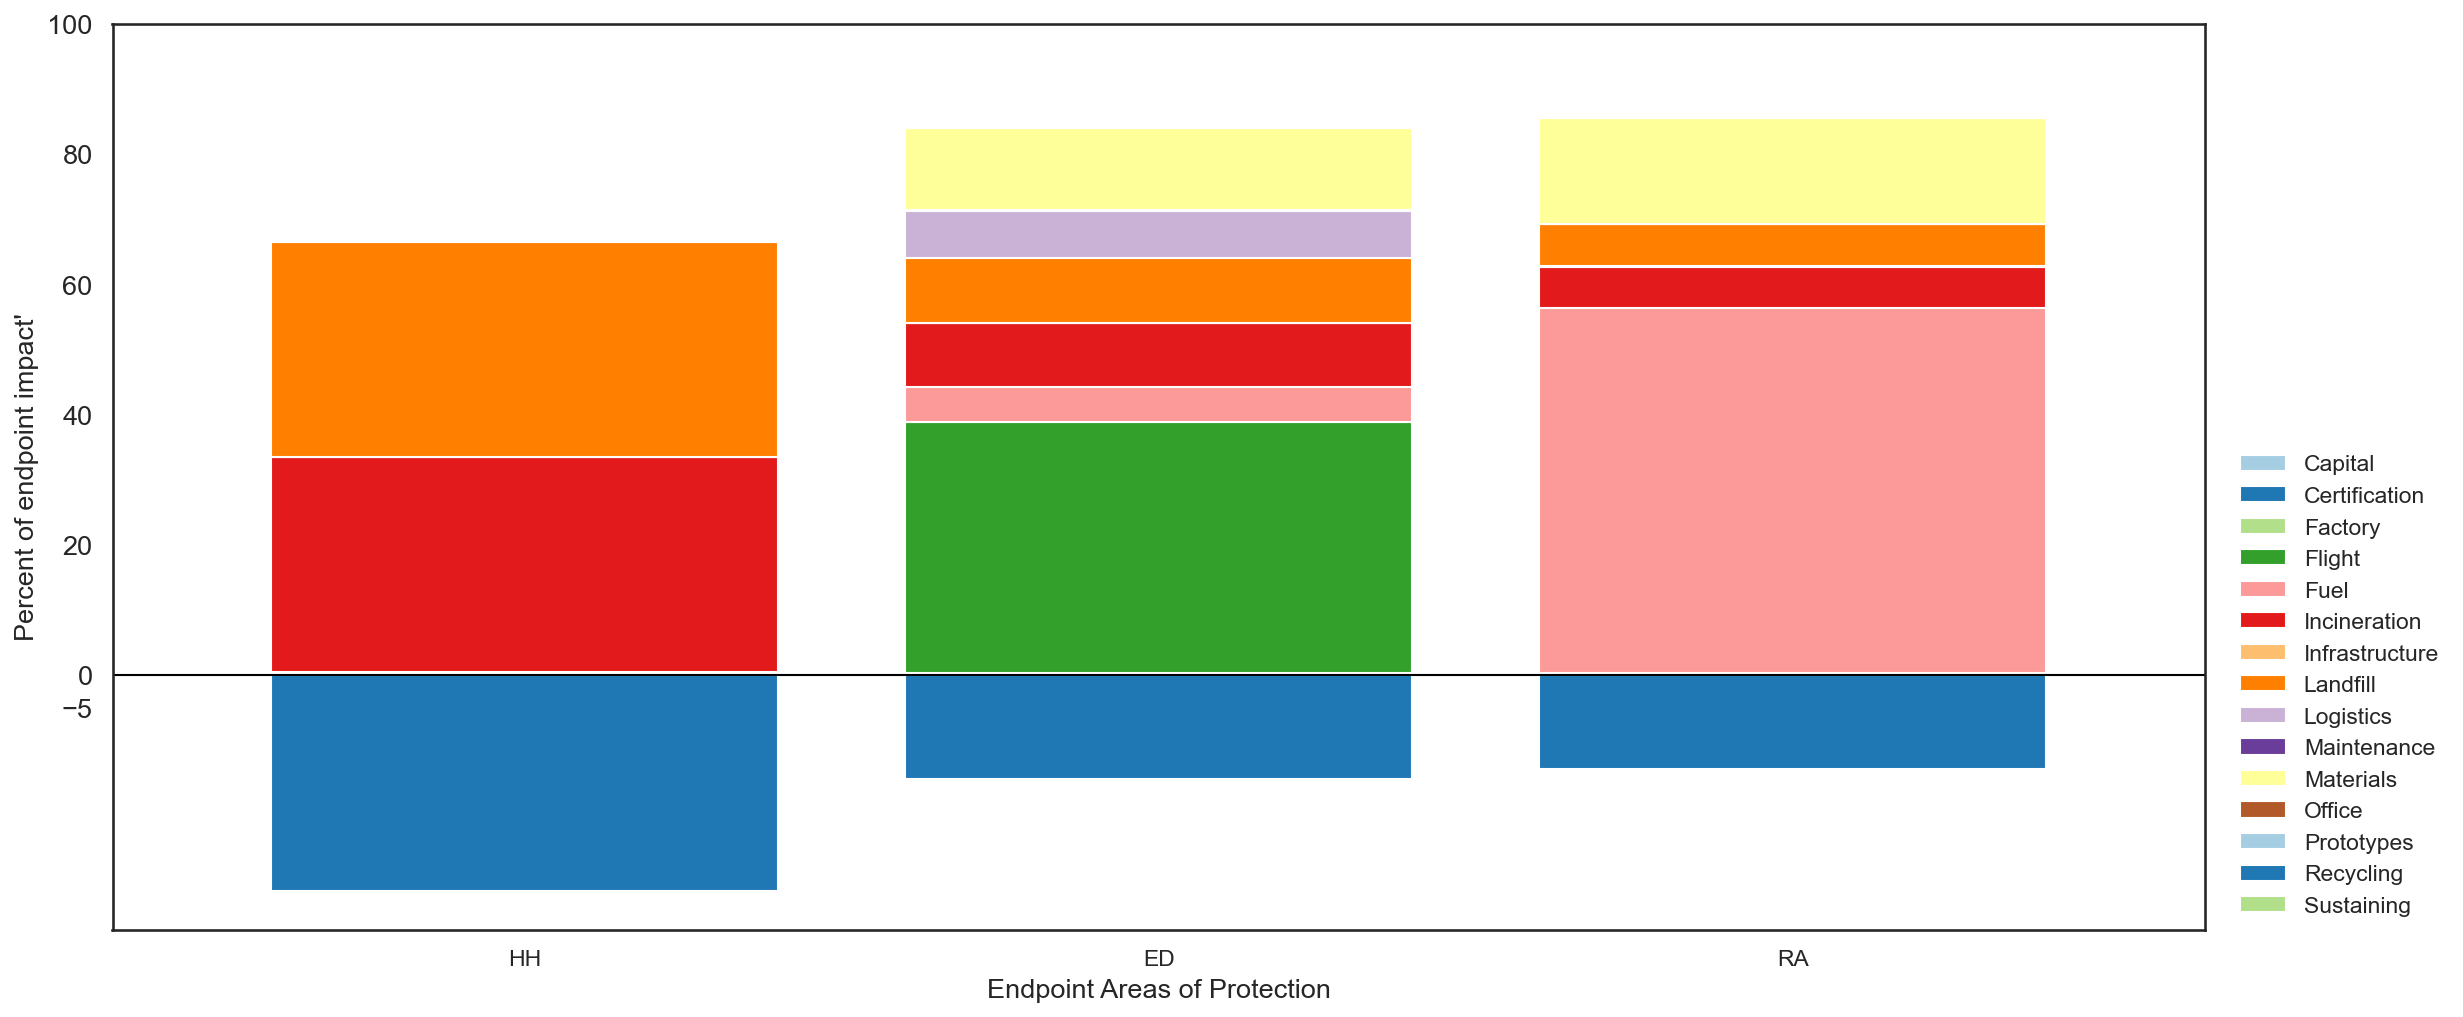

In [15]:
aeco_no_pest.bar('EP', subphase=True, save=False, palette=pal)

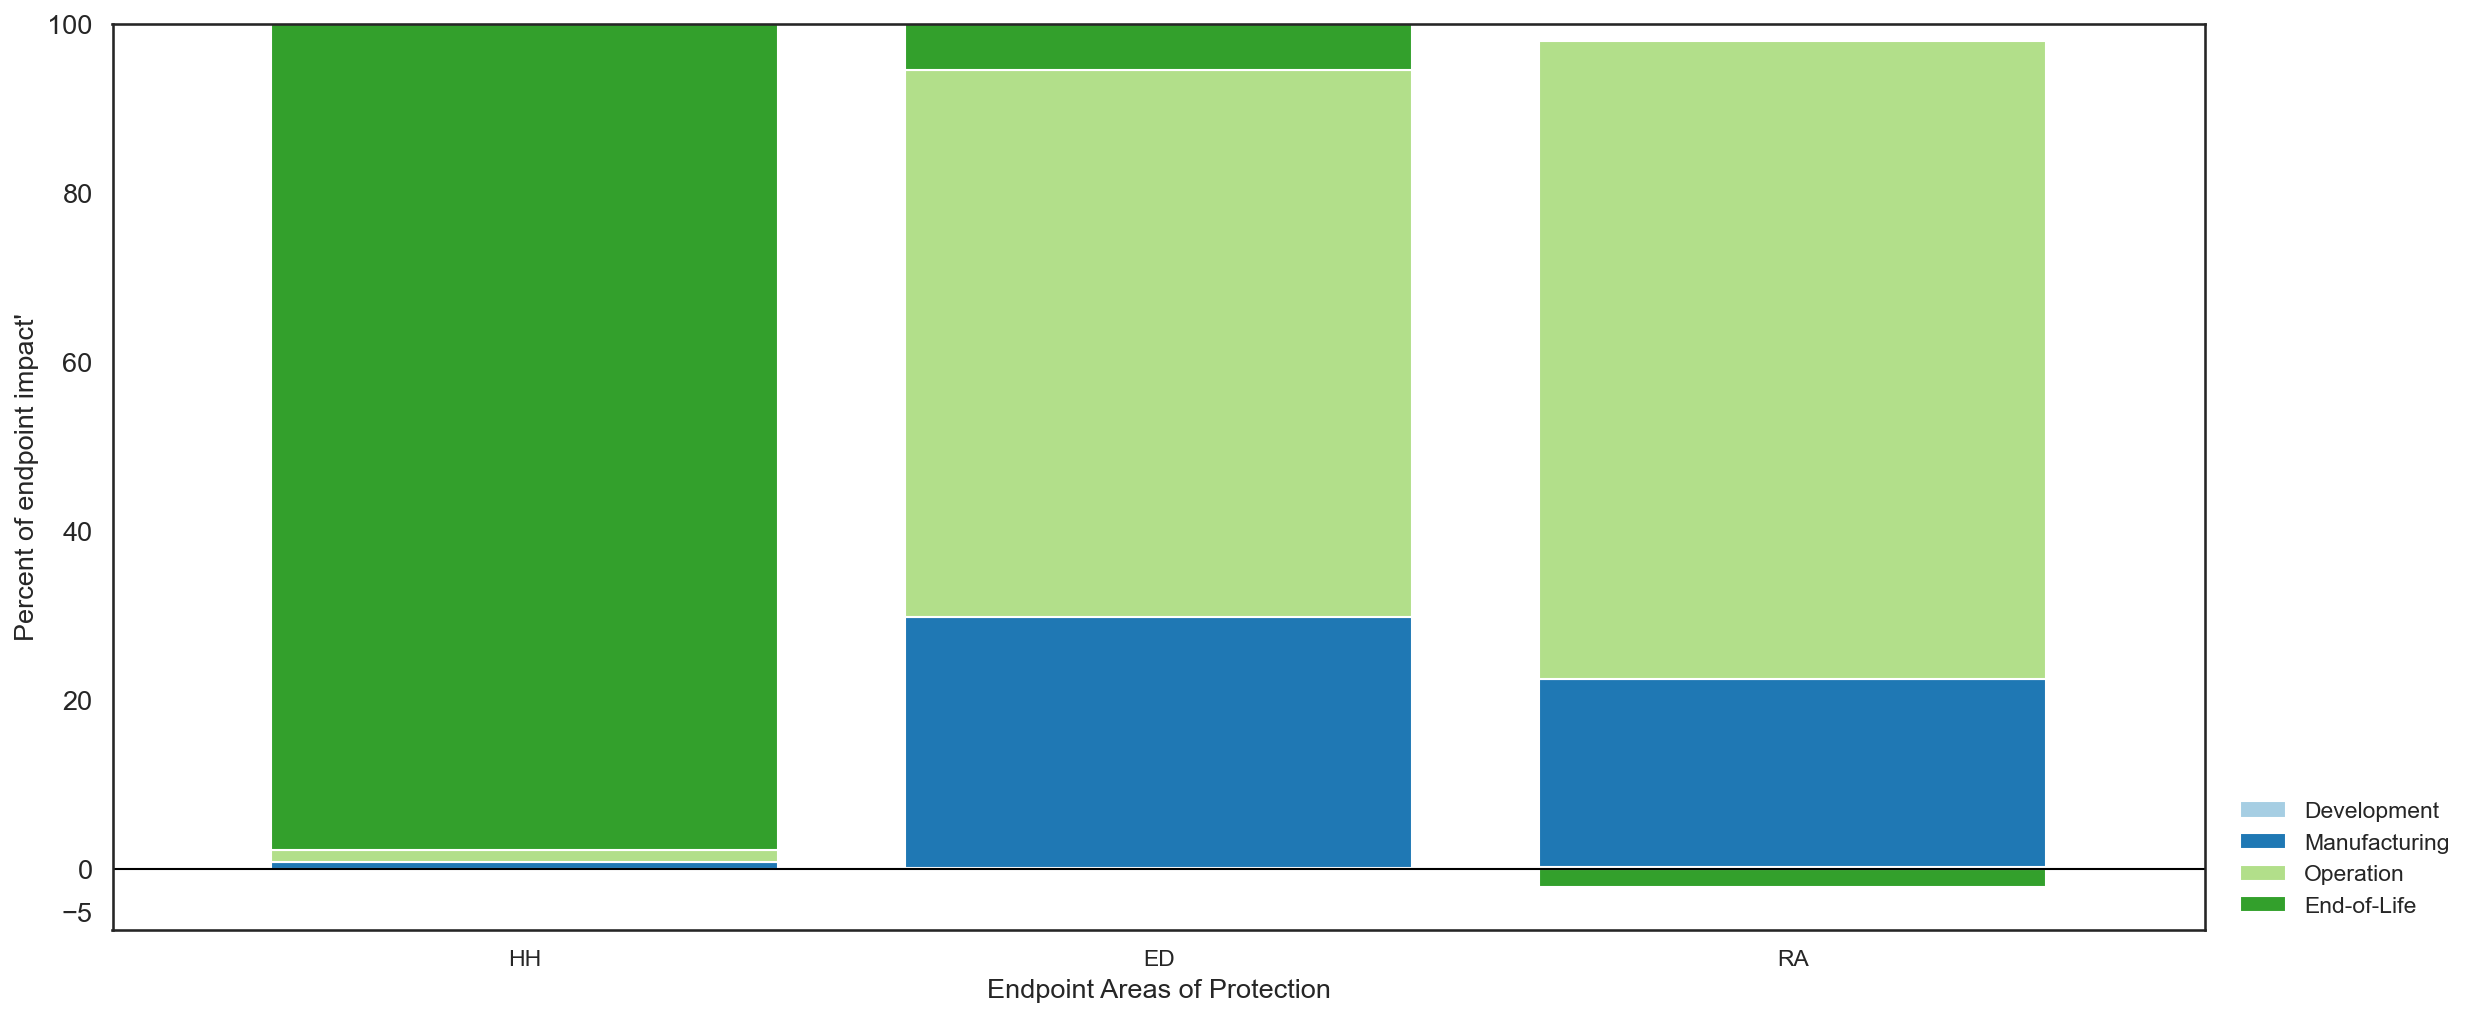

In [16]:
aeco_no_pest.bar('EP', subphase=False, save=False, palette=pal)

# Single Score Results

Mean SS results are shown below.

In [17]:
aeco_no_pest.SS("sum").mean('i').compute()

<xarray.DataArray ()>
array(0.53528423)

# CTV Results

The areas in the following plots represent CTV for each input parameters. Each plot concerns one midpoint or endpoint result. This plot is accessed through the `LCIA.square()` method.

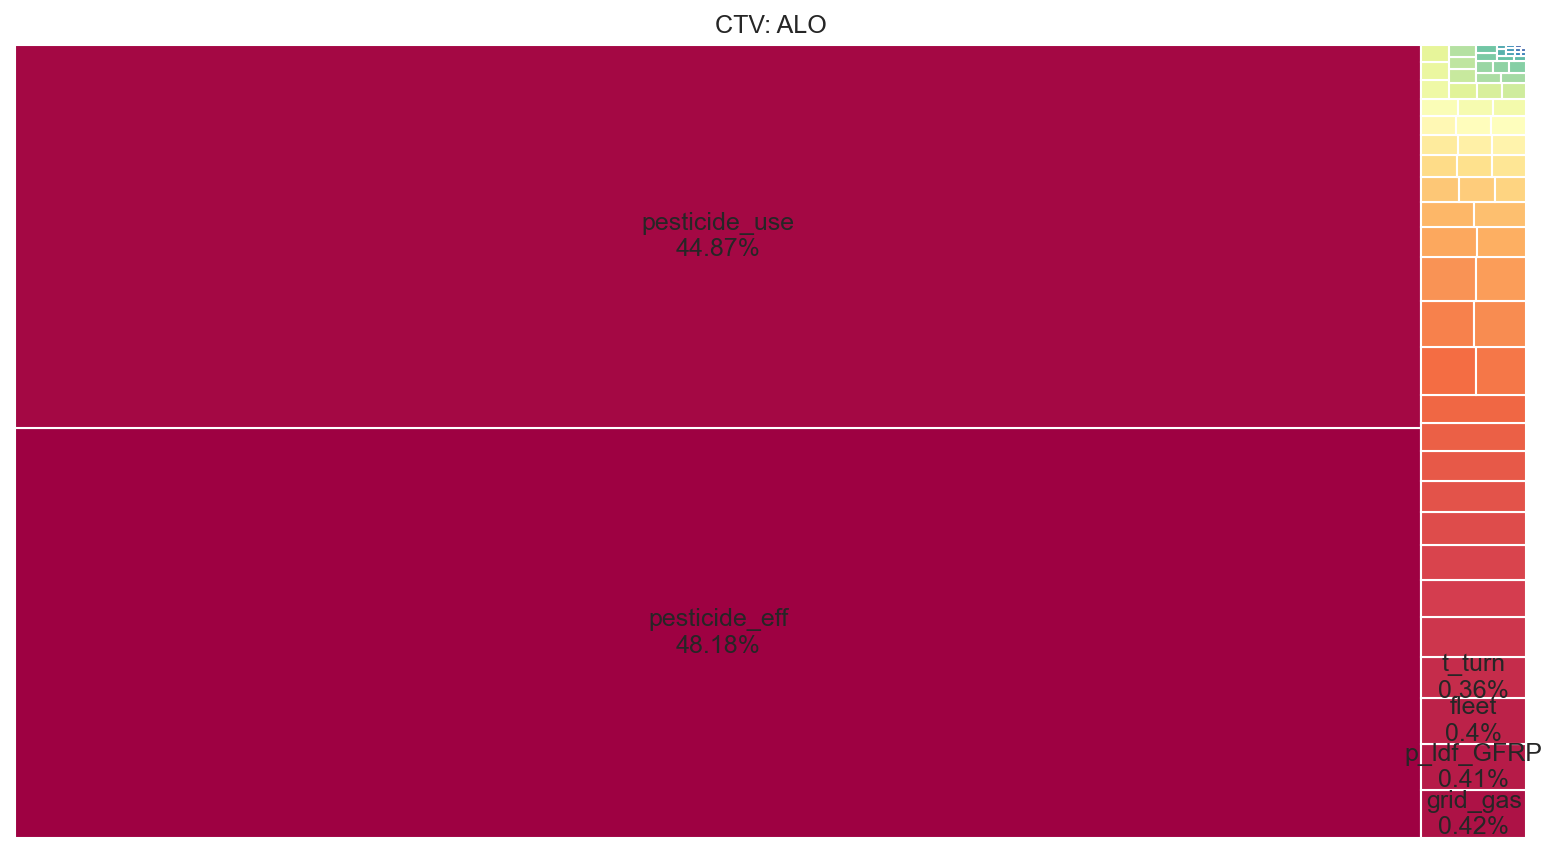

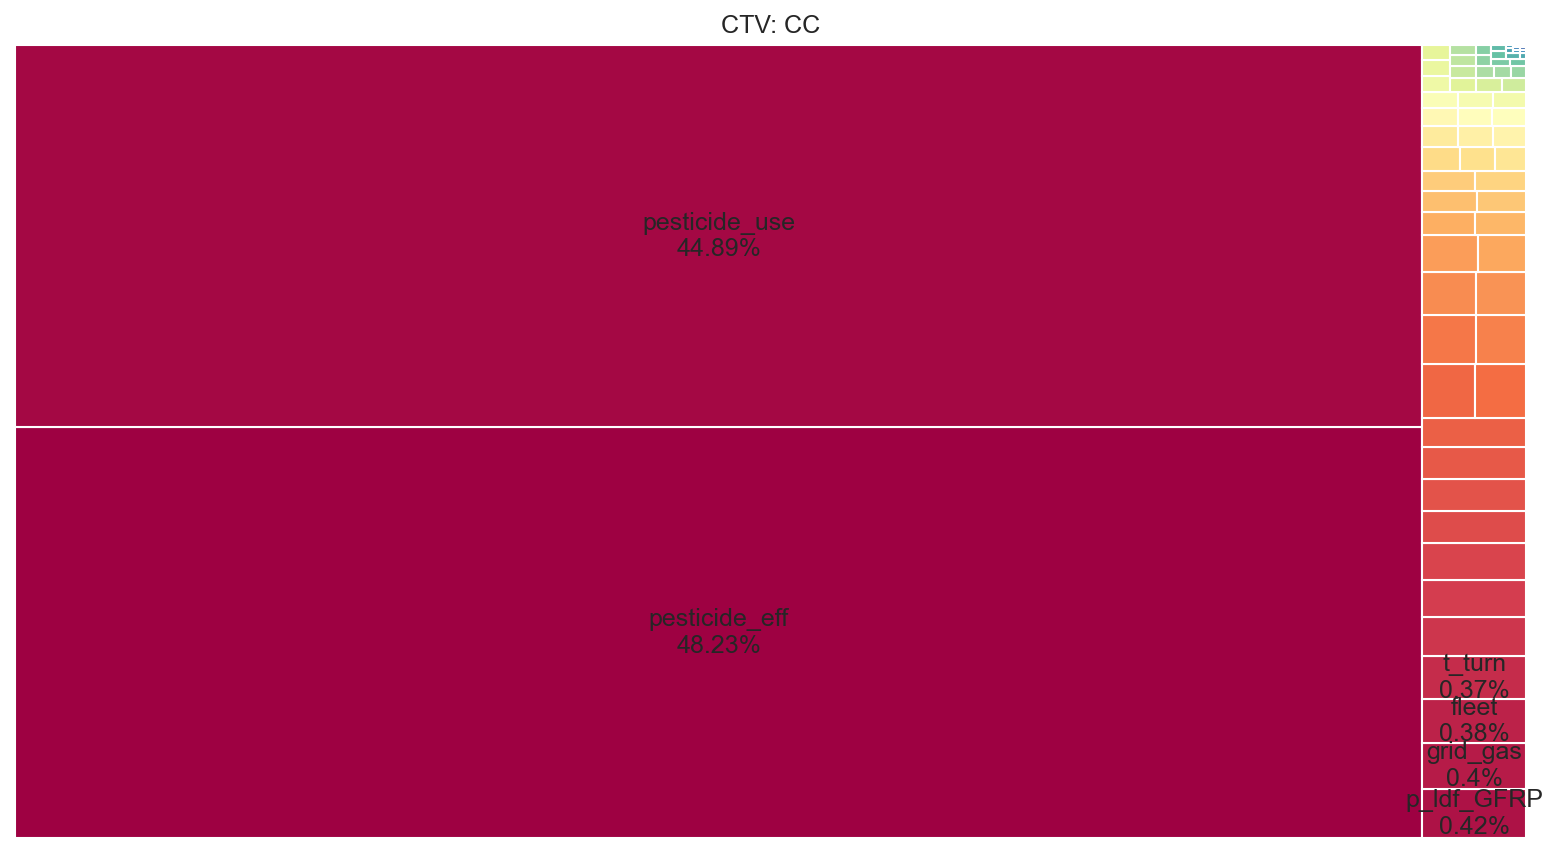

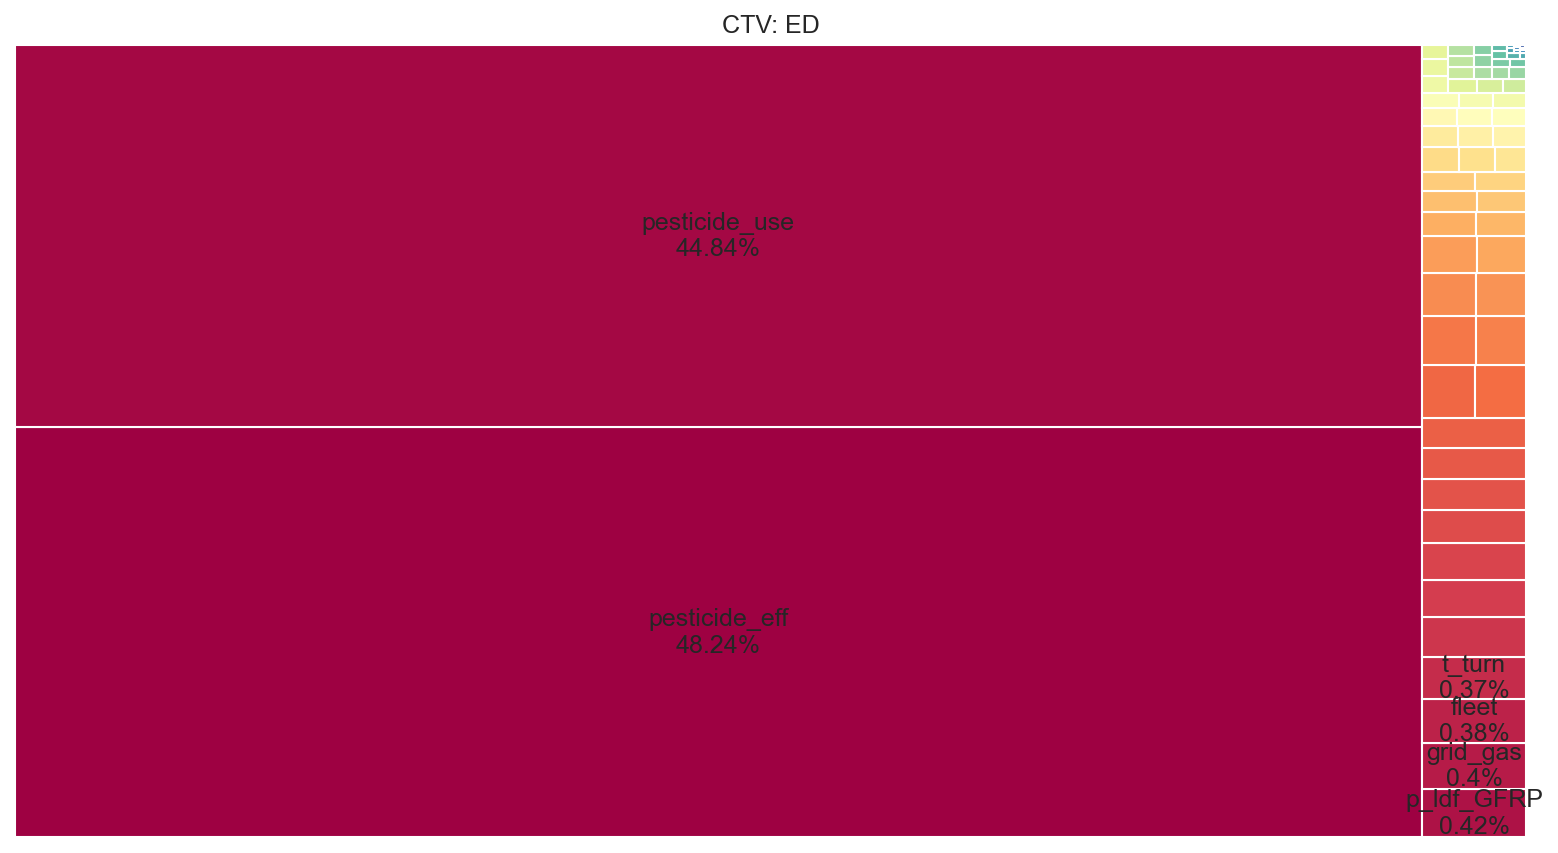

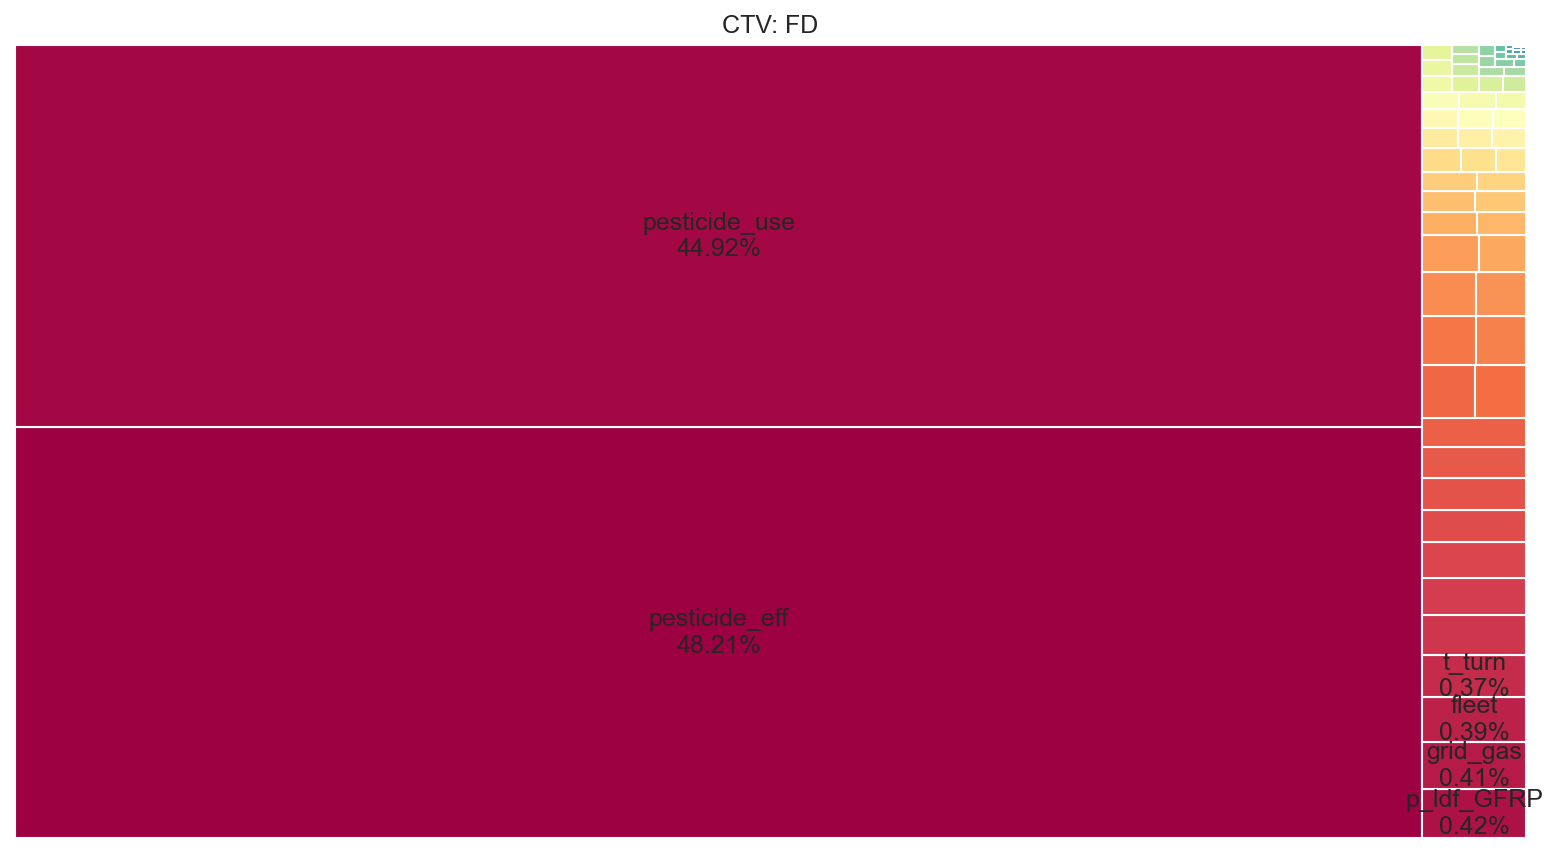

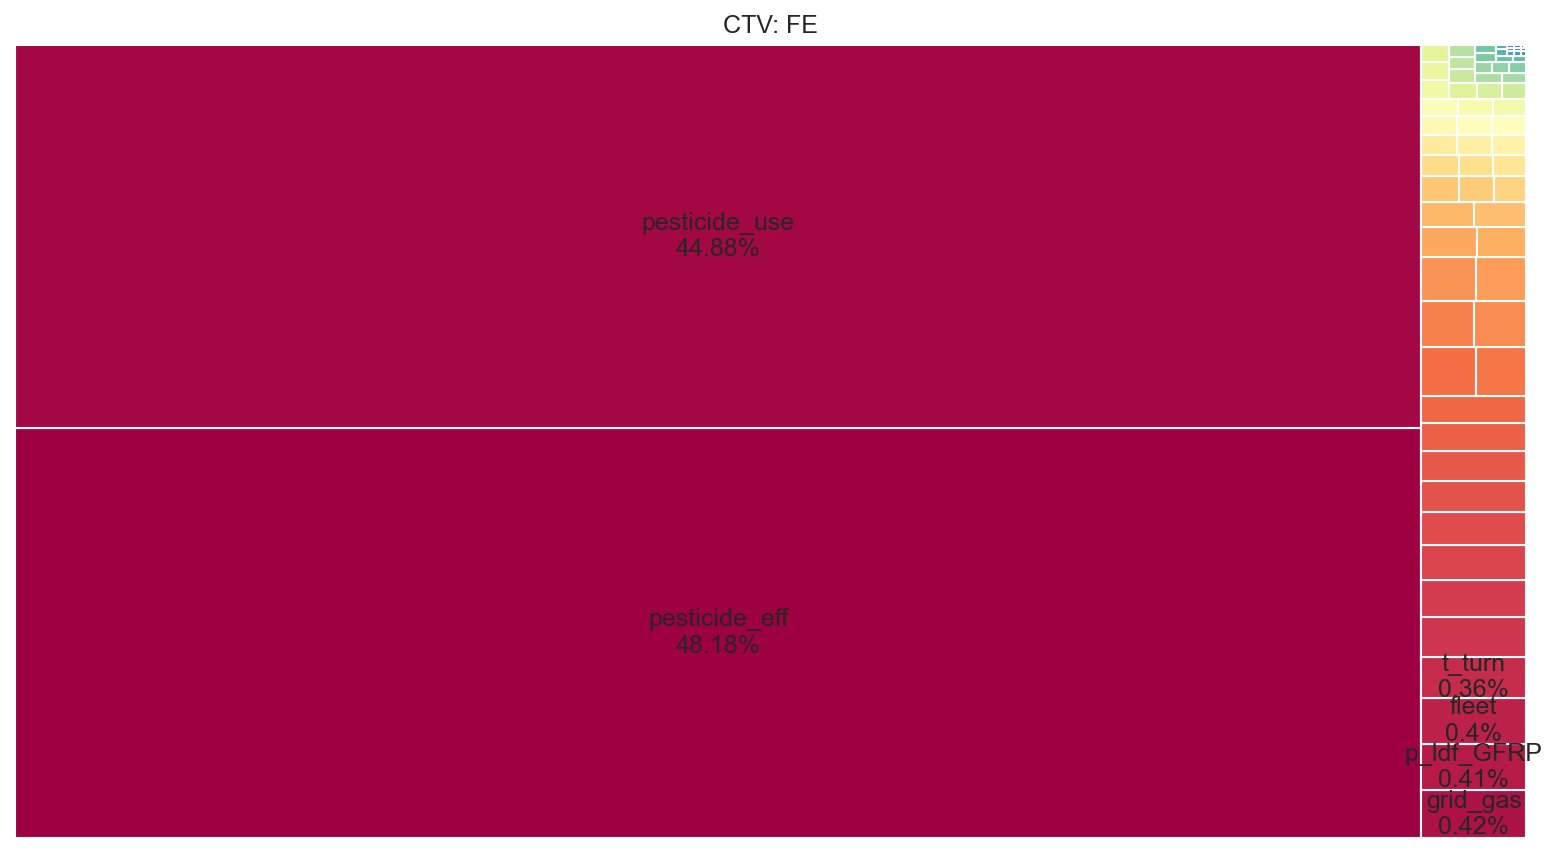

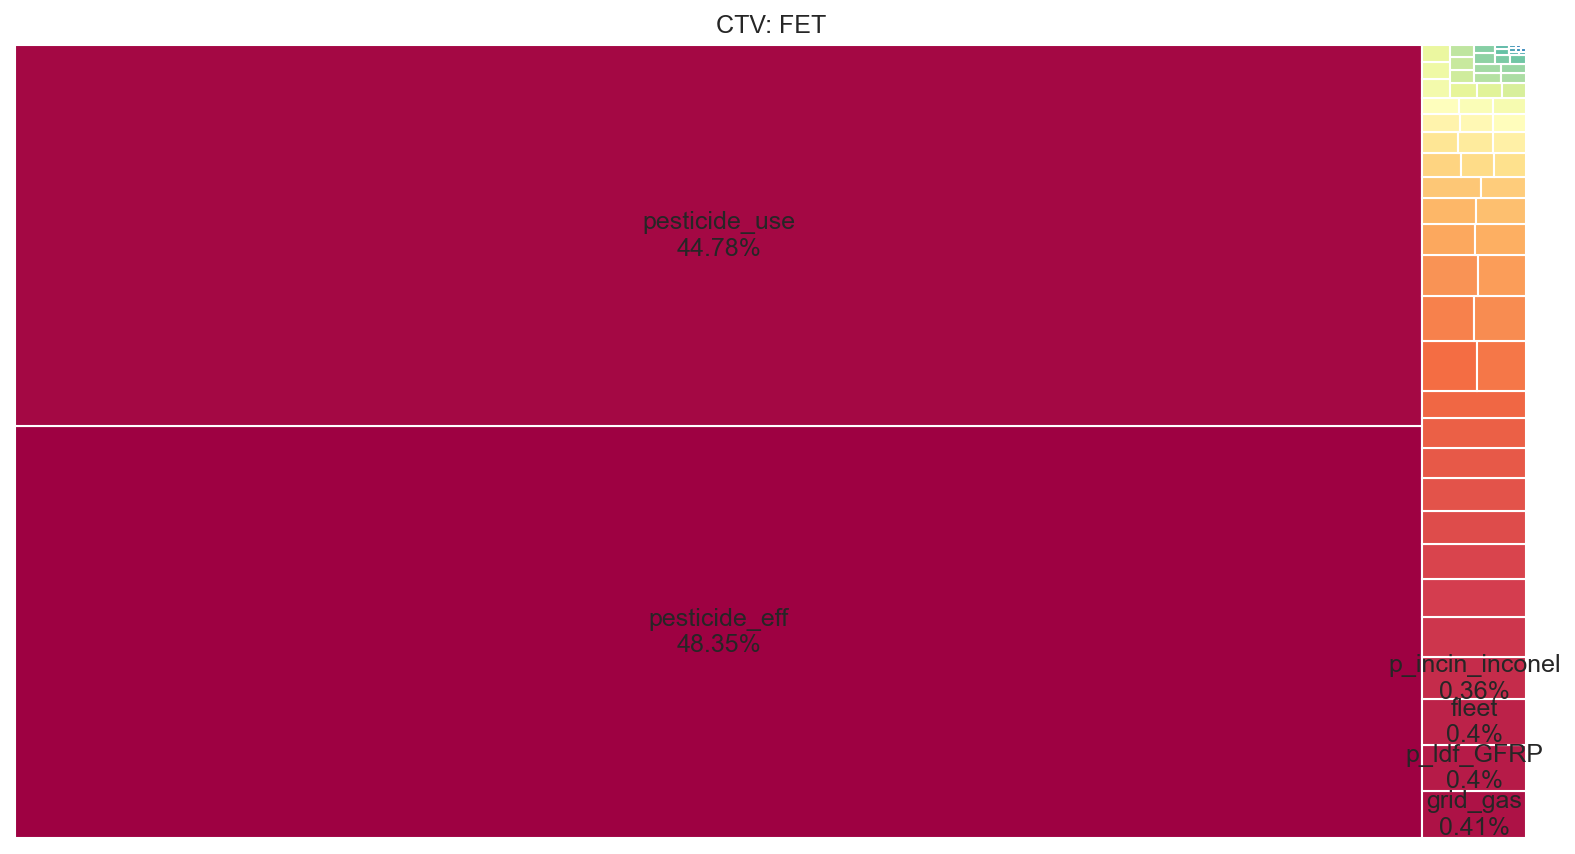

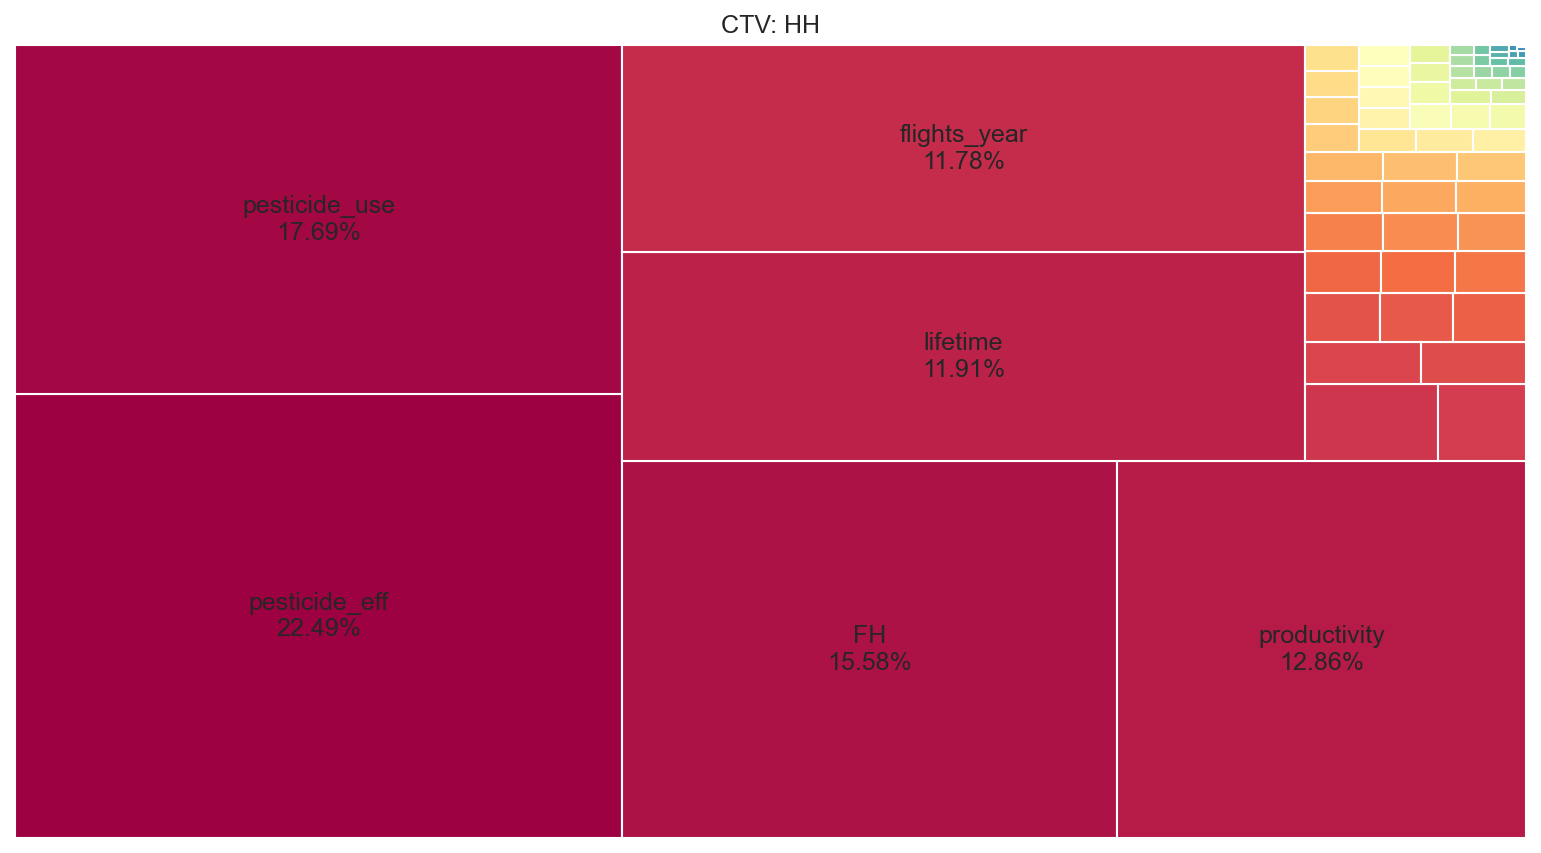

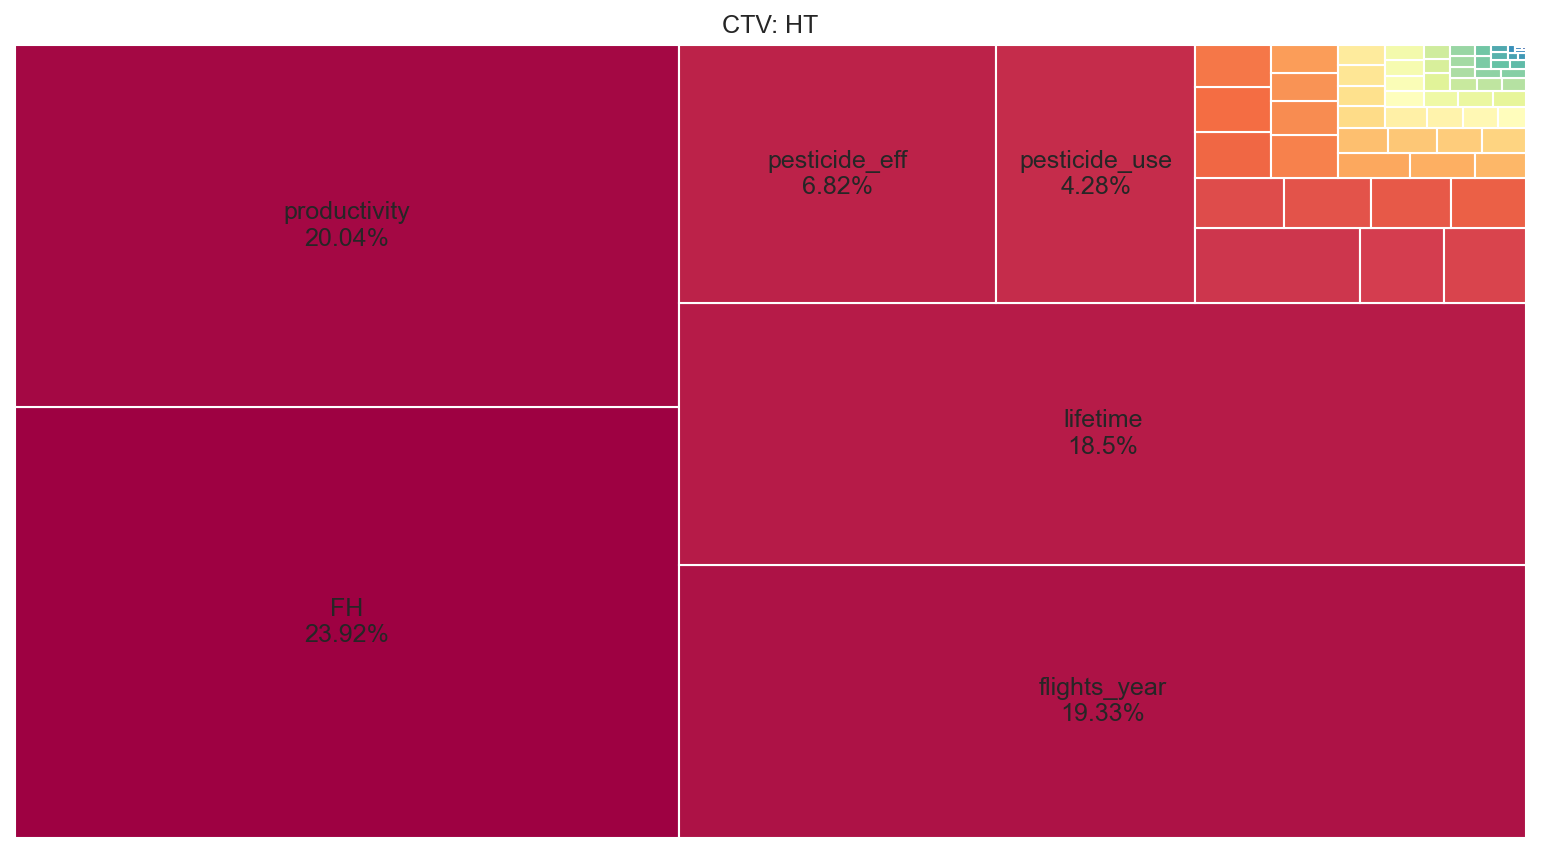

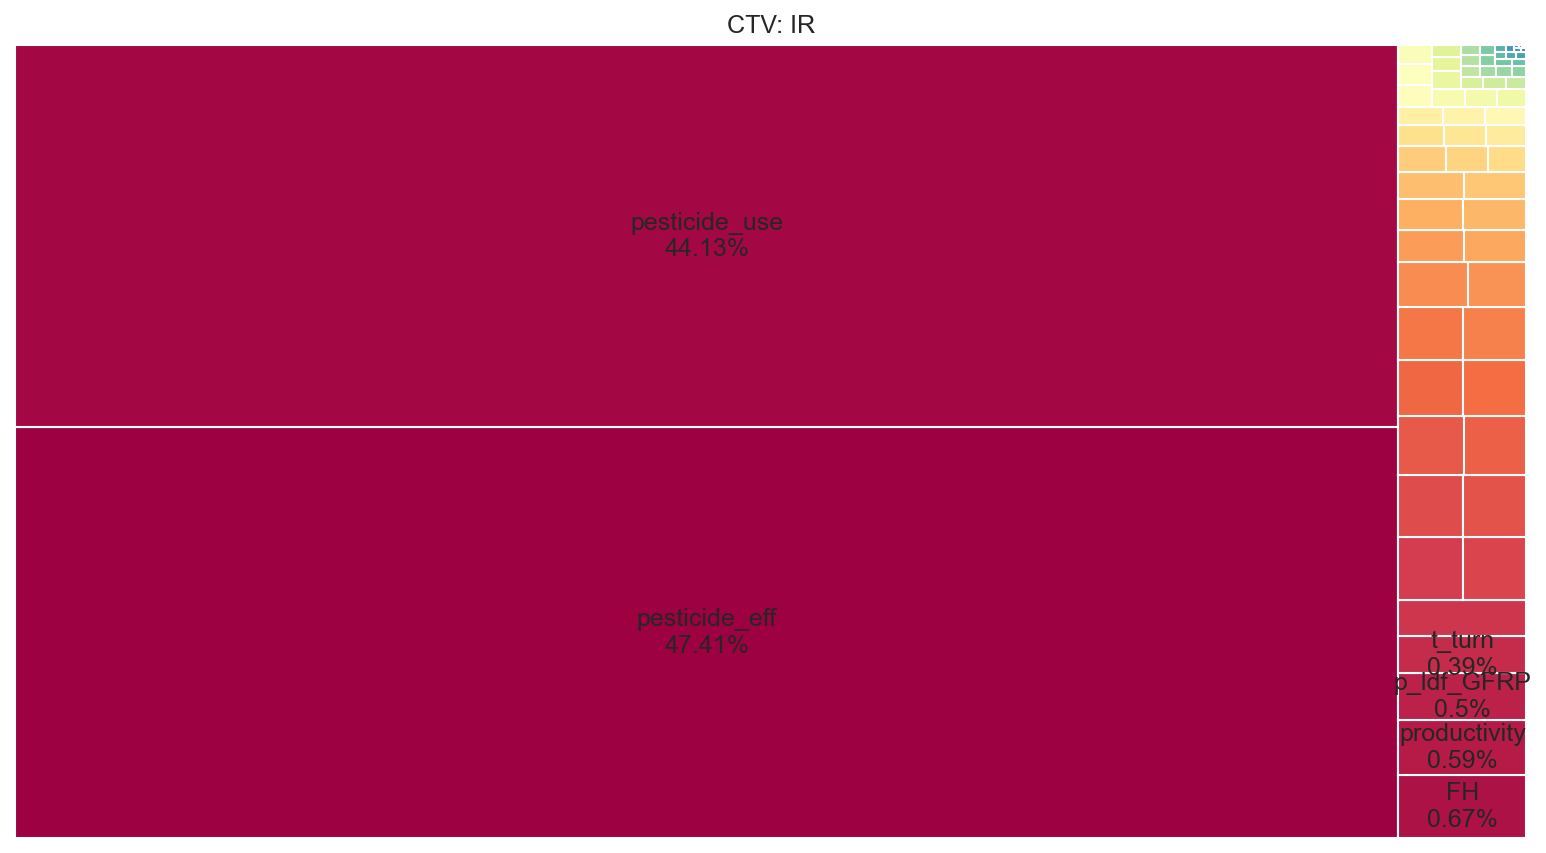

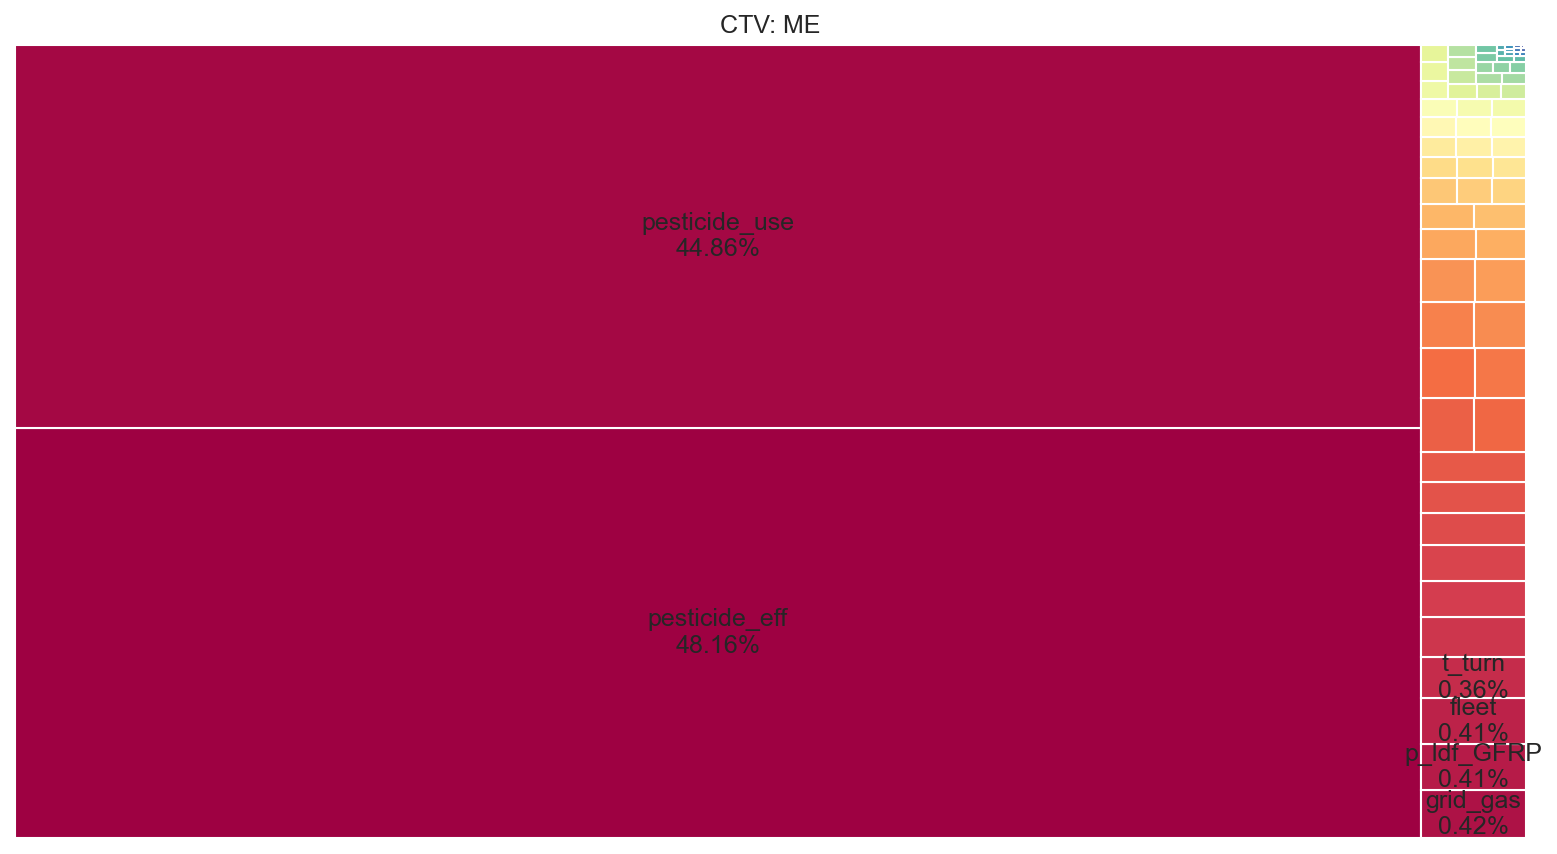

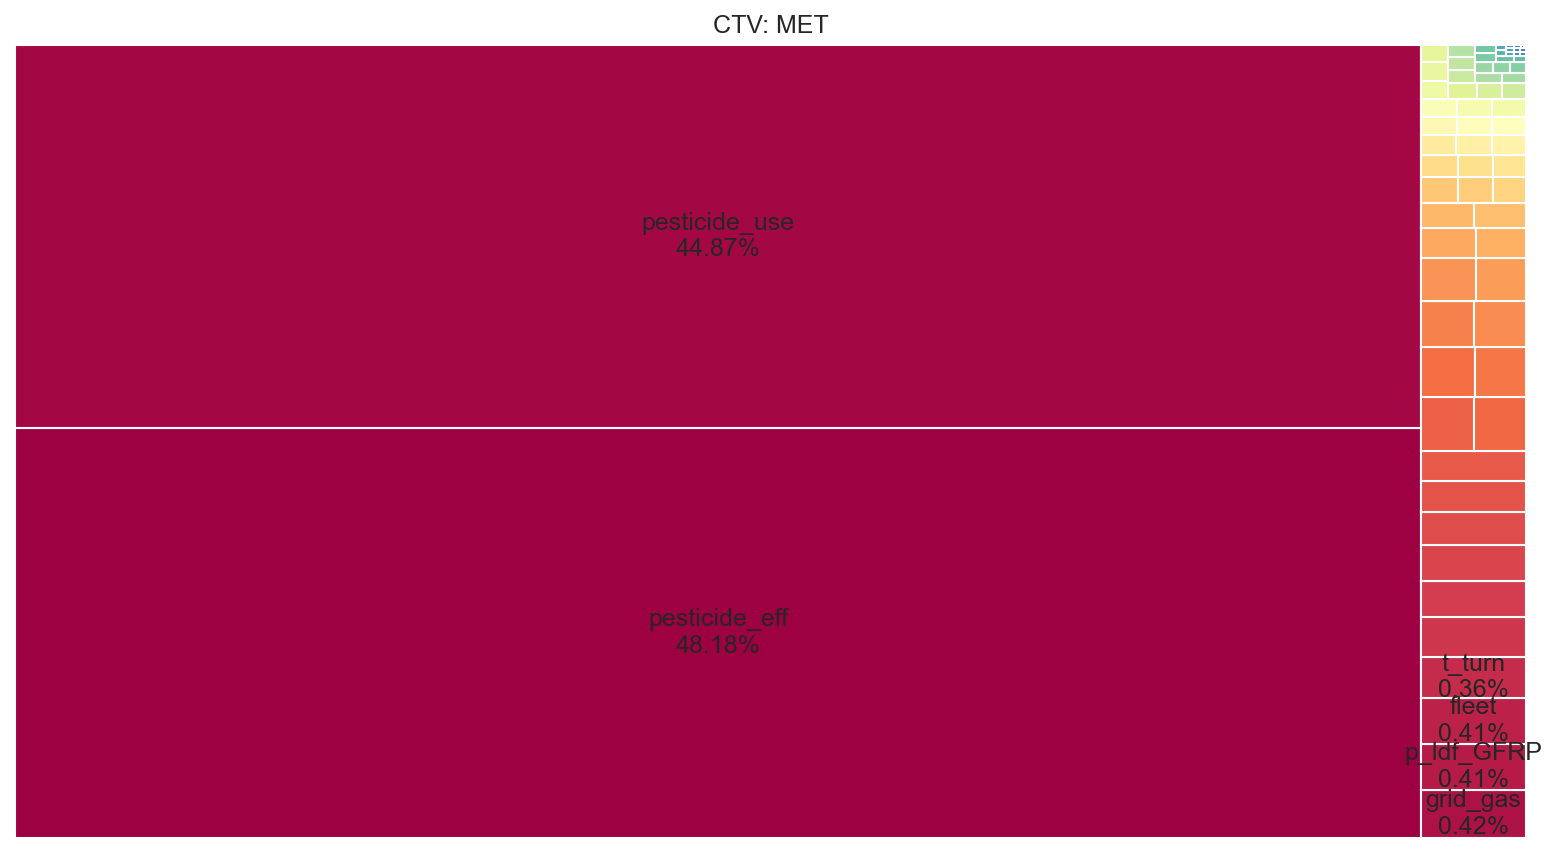

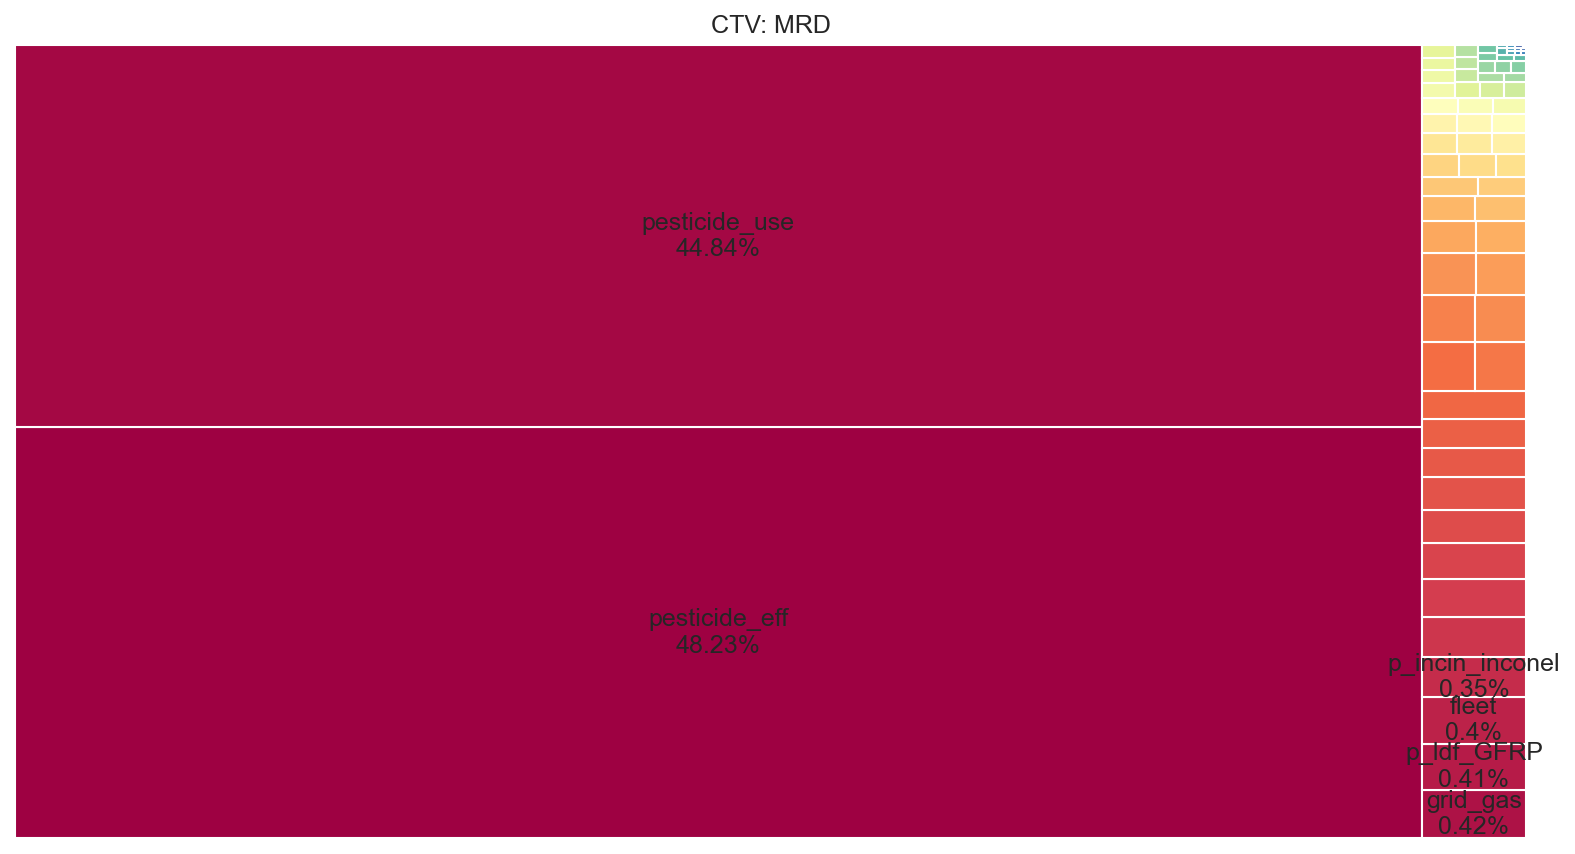

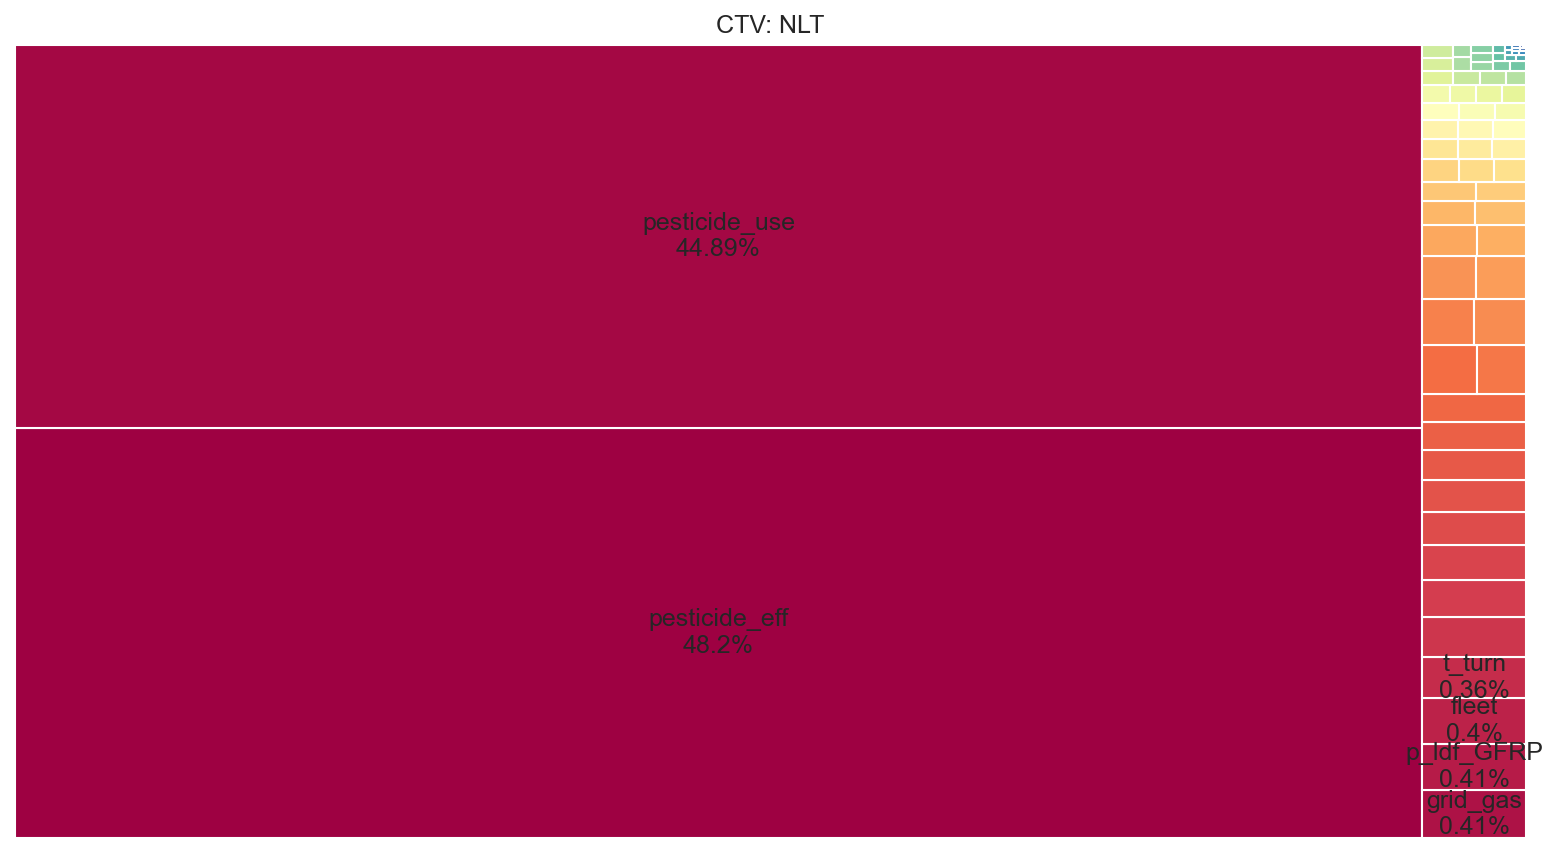

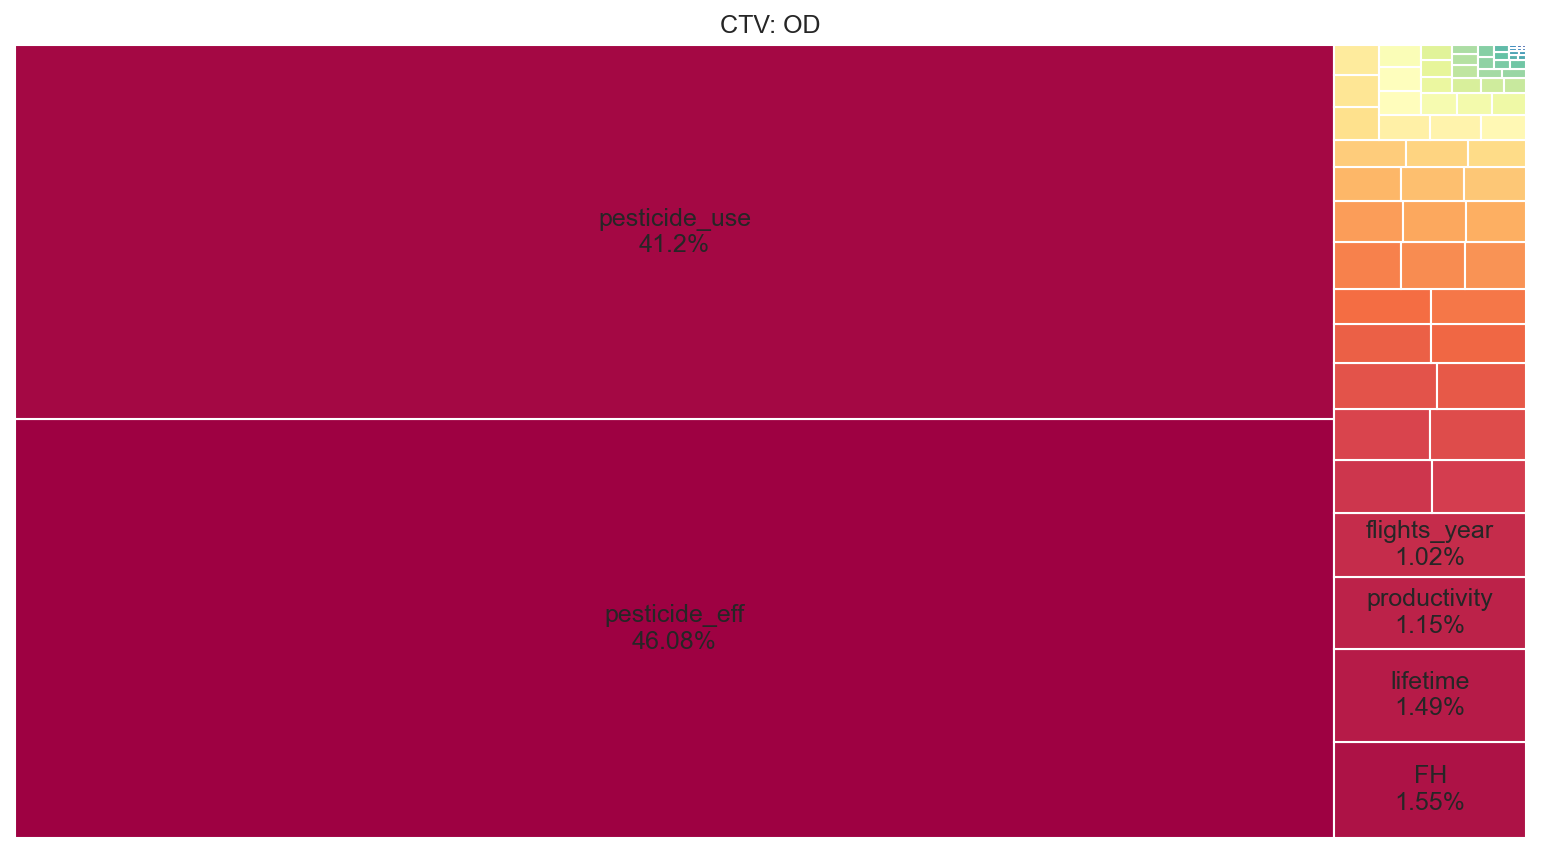

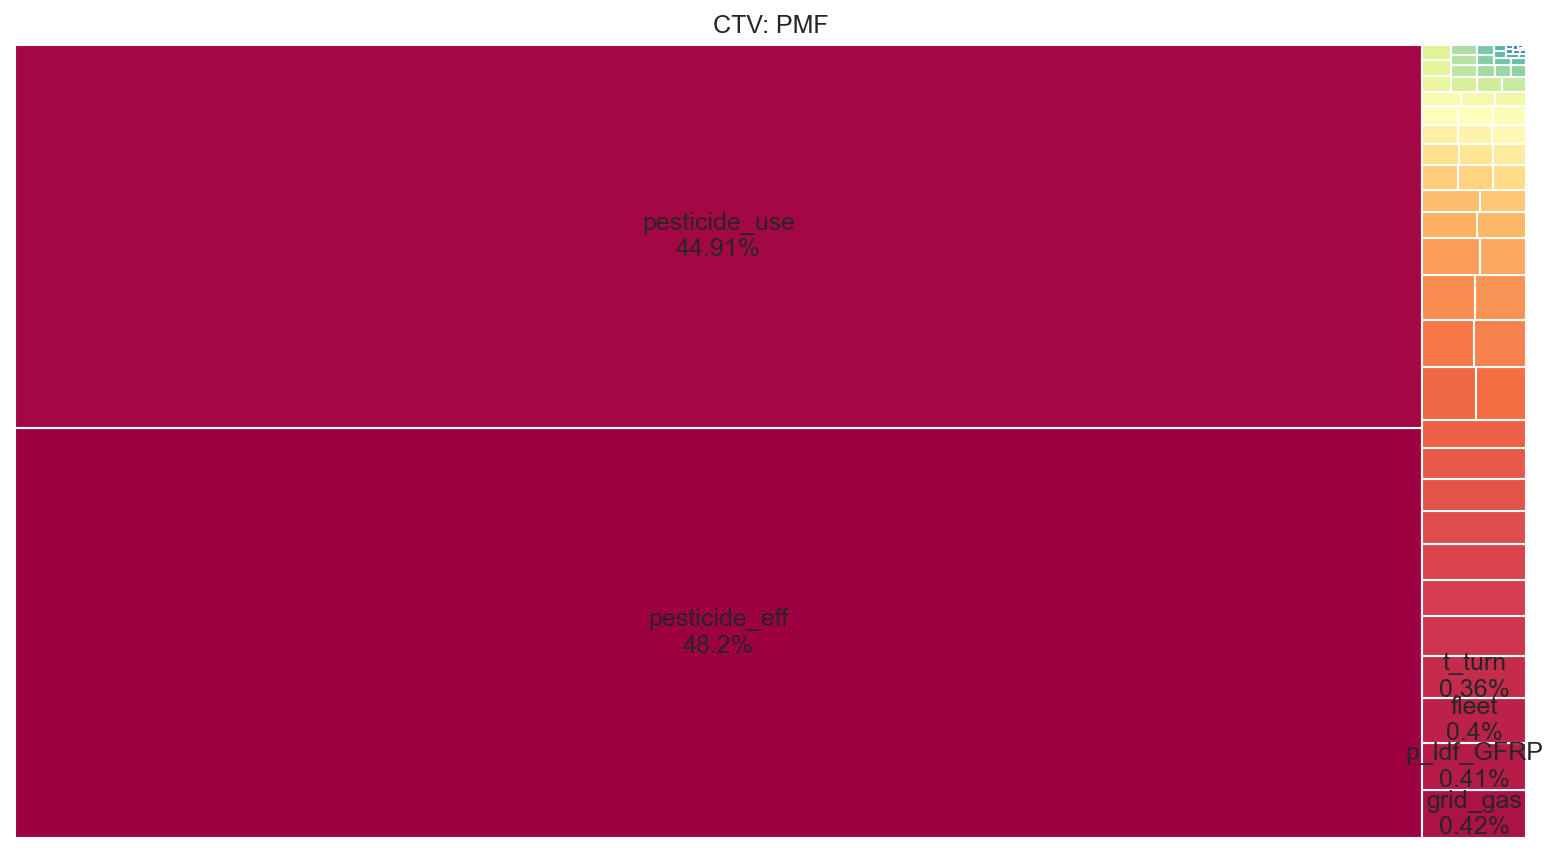

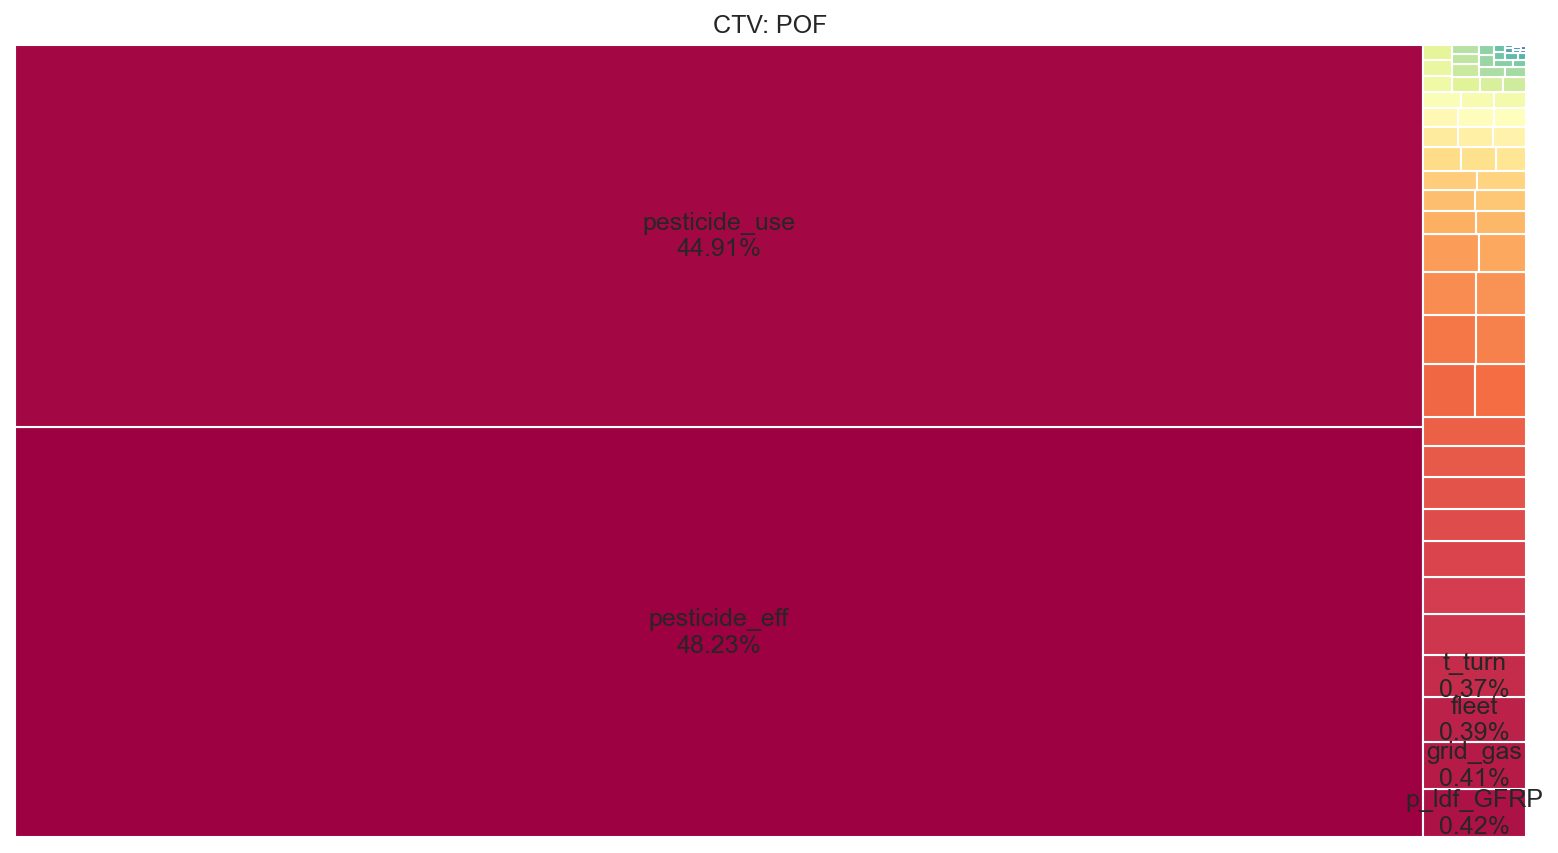

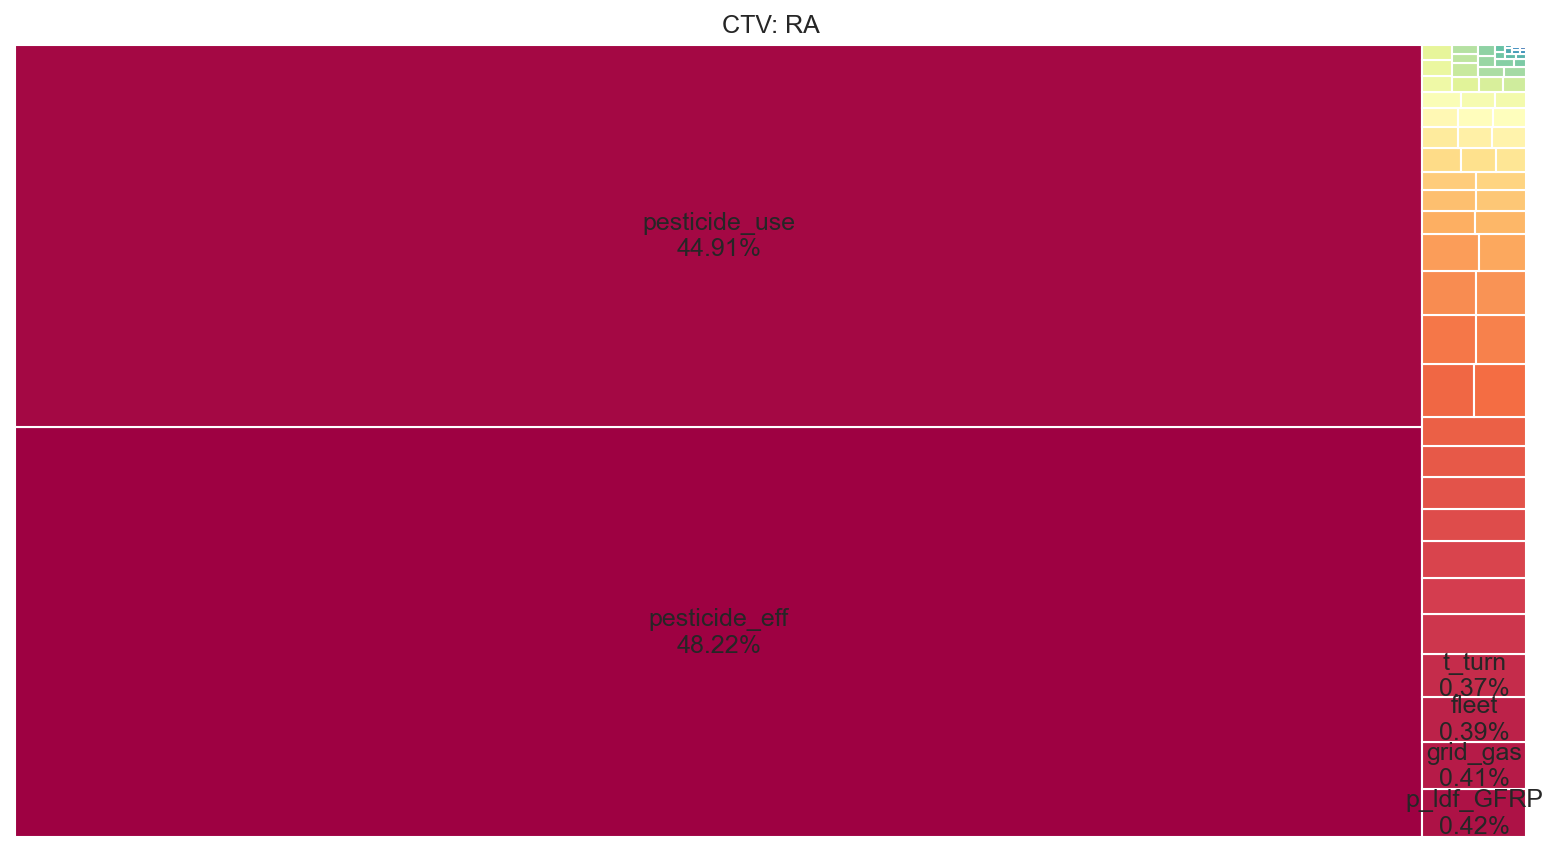

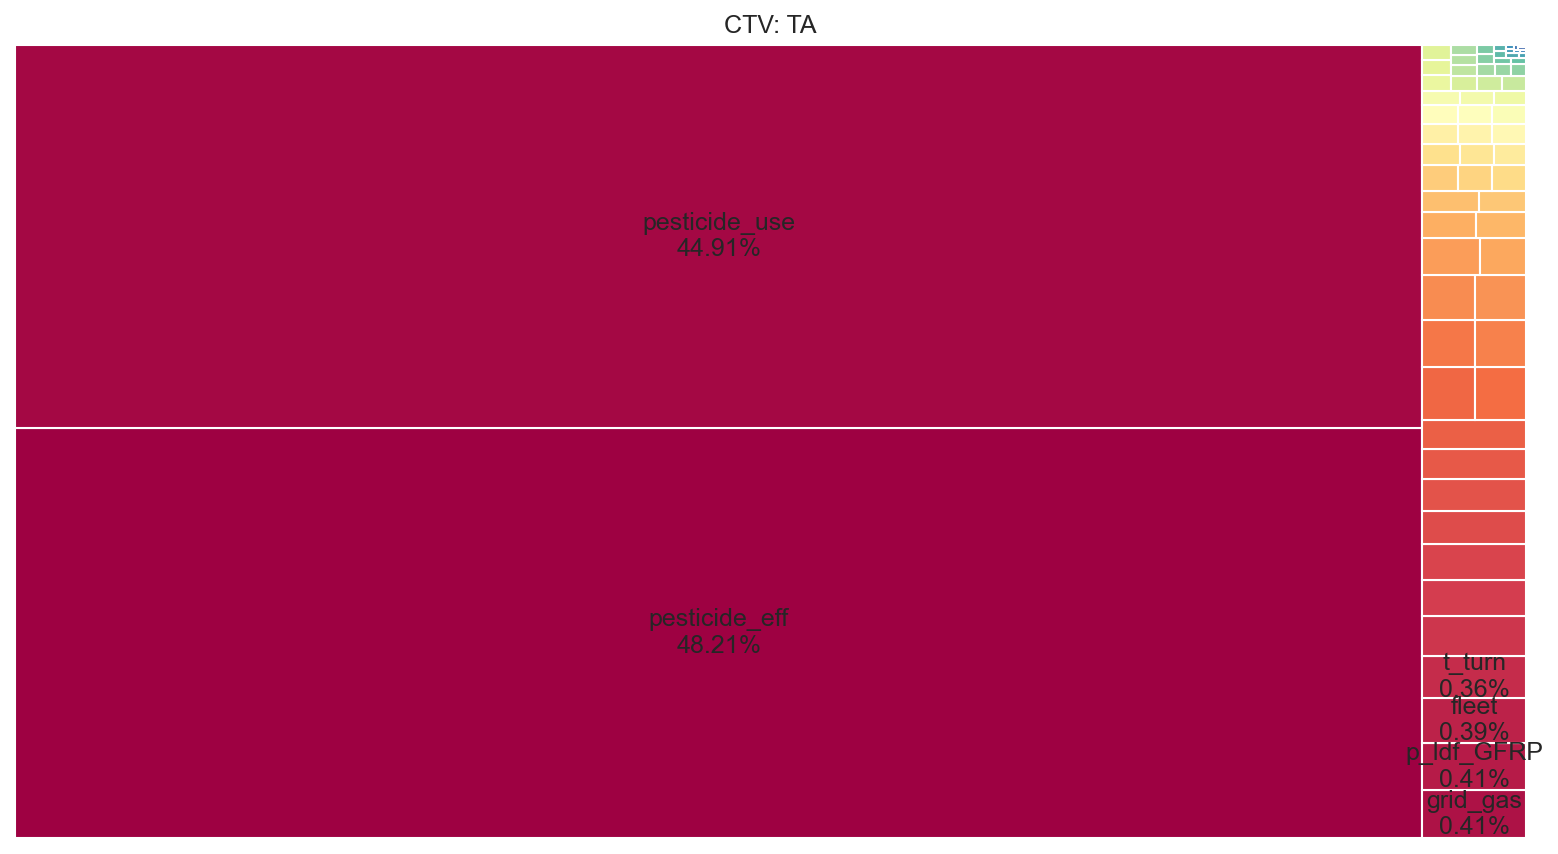

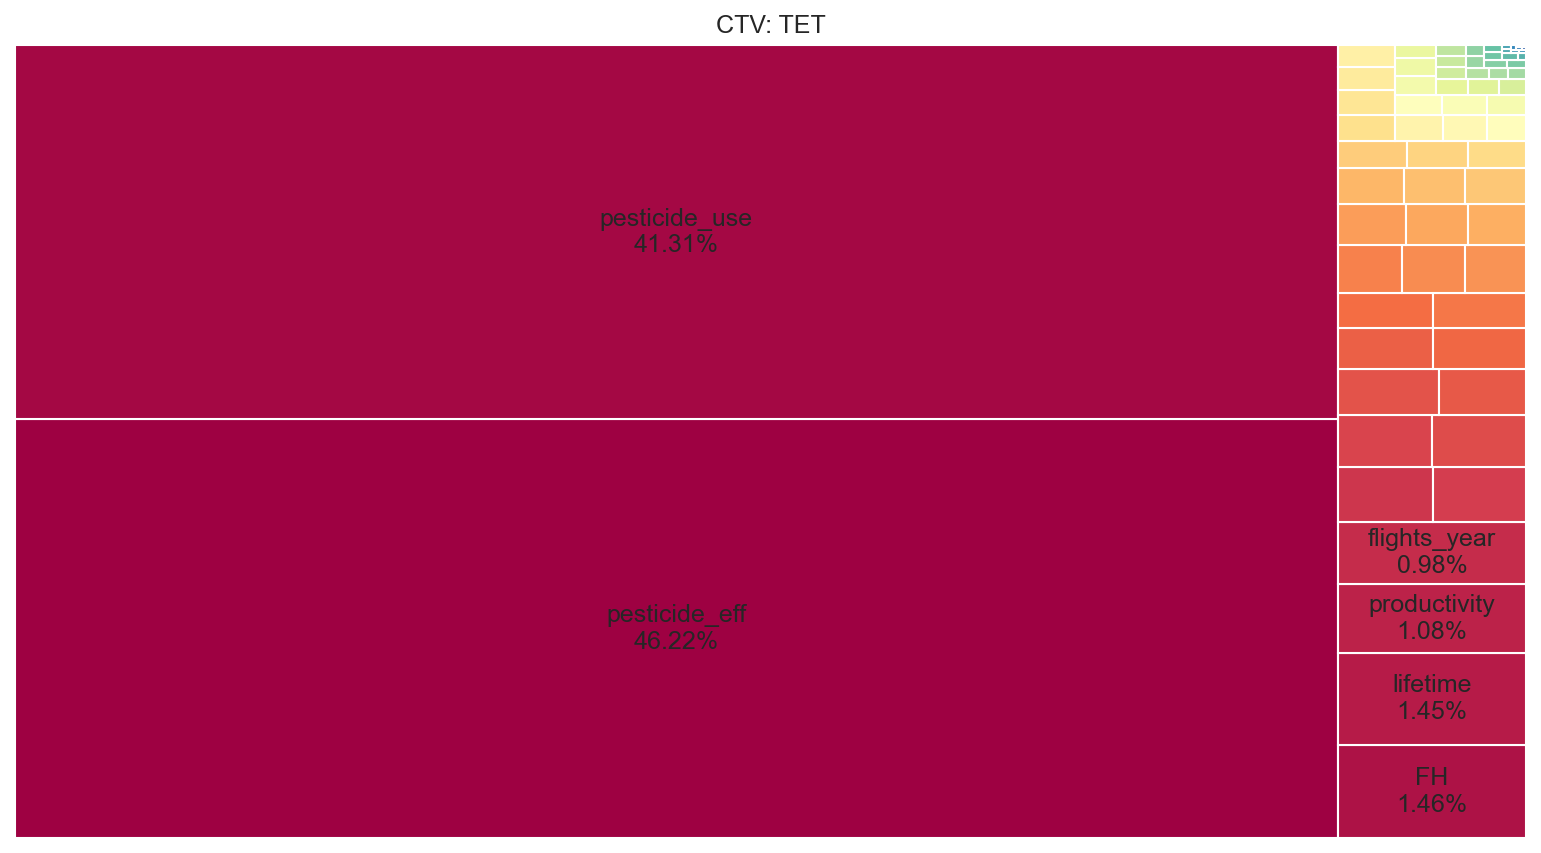

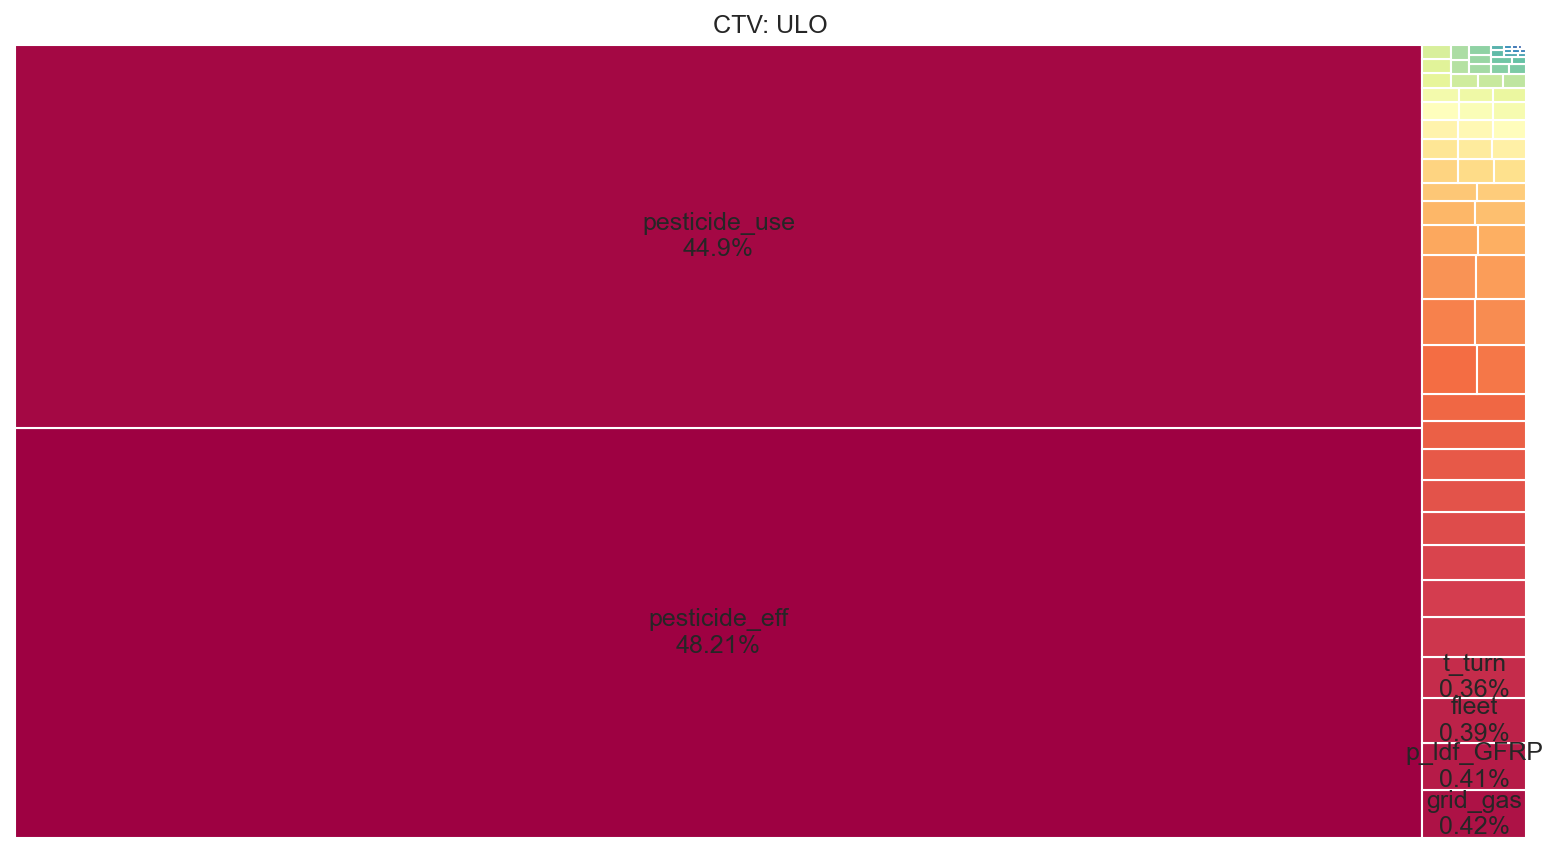

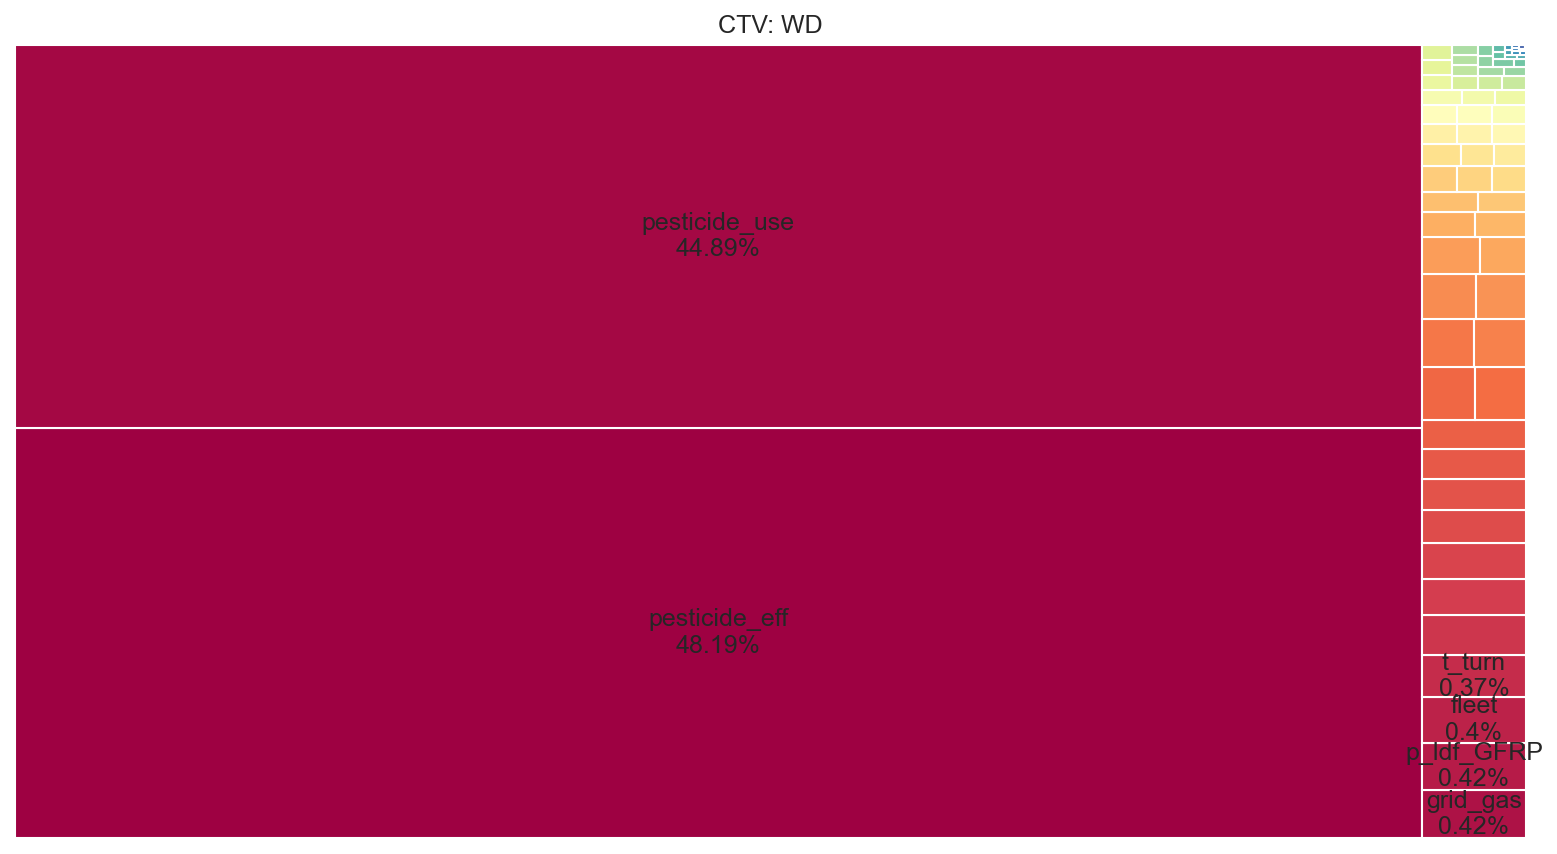

In [19]:
aeco_pest.square(save=False)

# Comparison

Comparison of two Datasets of LCIA results can be achieved by the `LCIA.compare` method, indicating the desired pathway.
In this paired comparison method, the iterations of the "Numerator" Dataset are divided by the "Denominator" Dataset, generating a Dataset of ratios. 

This new comparison Dataset has the same number of iterations than the original LCIA results Datasets, but, this time, each iteration represents a ratio.
Ratios less than one mean that the "Numerator" Dataset is advantageous, while ratios greater than one mean that the "Denominator" Dataset is favourable.
Using this logic, we can have an idea of which aircraft concept has fewer impacts by computing the mean of the iterations, using the `.mean('i')` or `.median('i')` command.

In [24]:
mistral_mp = echo.compare(bravo, pathway="MP")
mistral_ep = echo.compare(bravo, pathway="EP")

In [42]:
display(mistral_mp.compute().median('i'))
display(mistral_ep.compute().median('i'))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    FE       float64 0.9865
    MRD      float64 0.991
    POF      float64 0.9665
    MET      float64 0.9904
    TA       float64 0.9687
    ULO      float64 0.9777
    PMF      float64 0.969
    TET      float64 0.9682
    FET      float64 0.9886
    NLT      float64 0.9815
    OD       float64 0.9632
    ME       float64 0.9689
    ALO      float64 0.9632
    HT       float64 0.9826
    IR       float64 0.9627
    FD       float64 0.9638
    WD       float64 0.9635
    CC       float64 0.9661

<xarray.Dataset>
Dimensions:  ()
Data variables:
    HH       float64 0.9674
    ED       float64 0.9661
    RA       float64 0.9641

All Categories and all AOP have mean results slightly lower than one, meaning the Echo concept is slightly advantageous.

The same point can be proven by using the `comparePercent` function.
The function shows, in percentage, how many of the iterations are below the threshold of one, meaning how many iterations favour Echo over Bravo.

In [32]:
display(comparePercent(mistral_mp))
display(comparePercent(mistral_ep))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    FE       float64 52.83
    MRD      float64 51.83
    POF      float64 56.5
    MET      float64 51.94
    TA       float64 56.0
    ULO      float64 54.51
    PMF      float64 55.91
    TET      float64 56.17
    FET      float64 52.29
    NLT      float64 53.62
    OD       float64 57.1
    ME       float64 55.96
    ALO      float64 57.37
    HT       float64 53.73
    IR       float64 57.15
    FD       float64 57.01
    WD       float64 56.76
    CC       float64 56.5
Attributes:
    Numerator:    Echo
    Denominator:  Bravo

<xarray.Dataset>
Dimensions:  ()
Data variables:
    HH       float64 56.27
    ED       float64 56.47
    RA       float64 56.95
Attributes:
    Numerator:    Echo
    Denominator:  Bravo

This can be better visualized using the `LCIA.dist_compare()` method, which plots the paired distribution of both concepts.

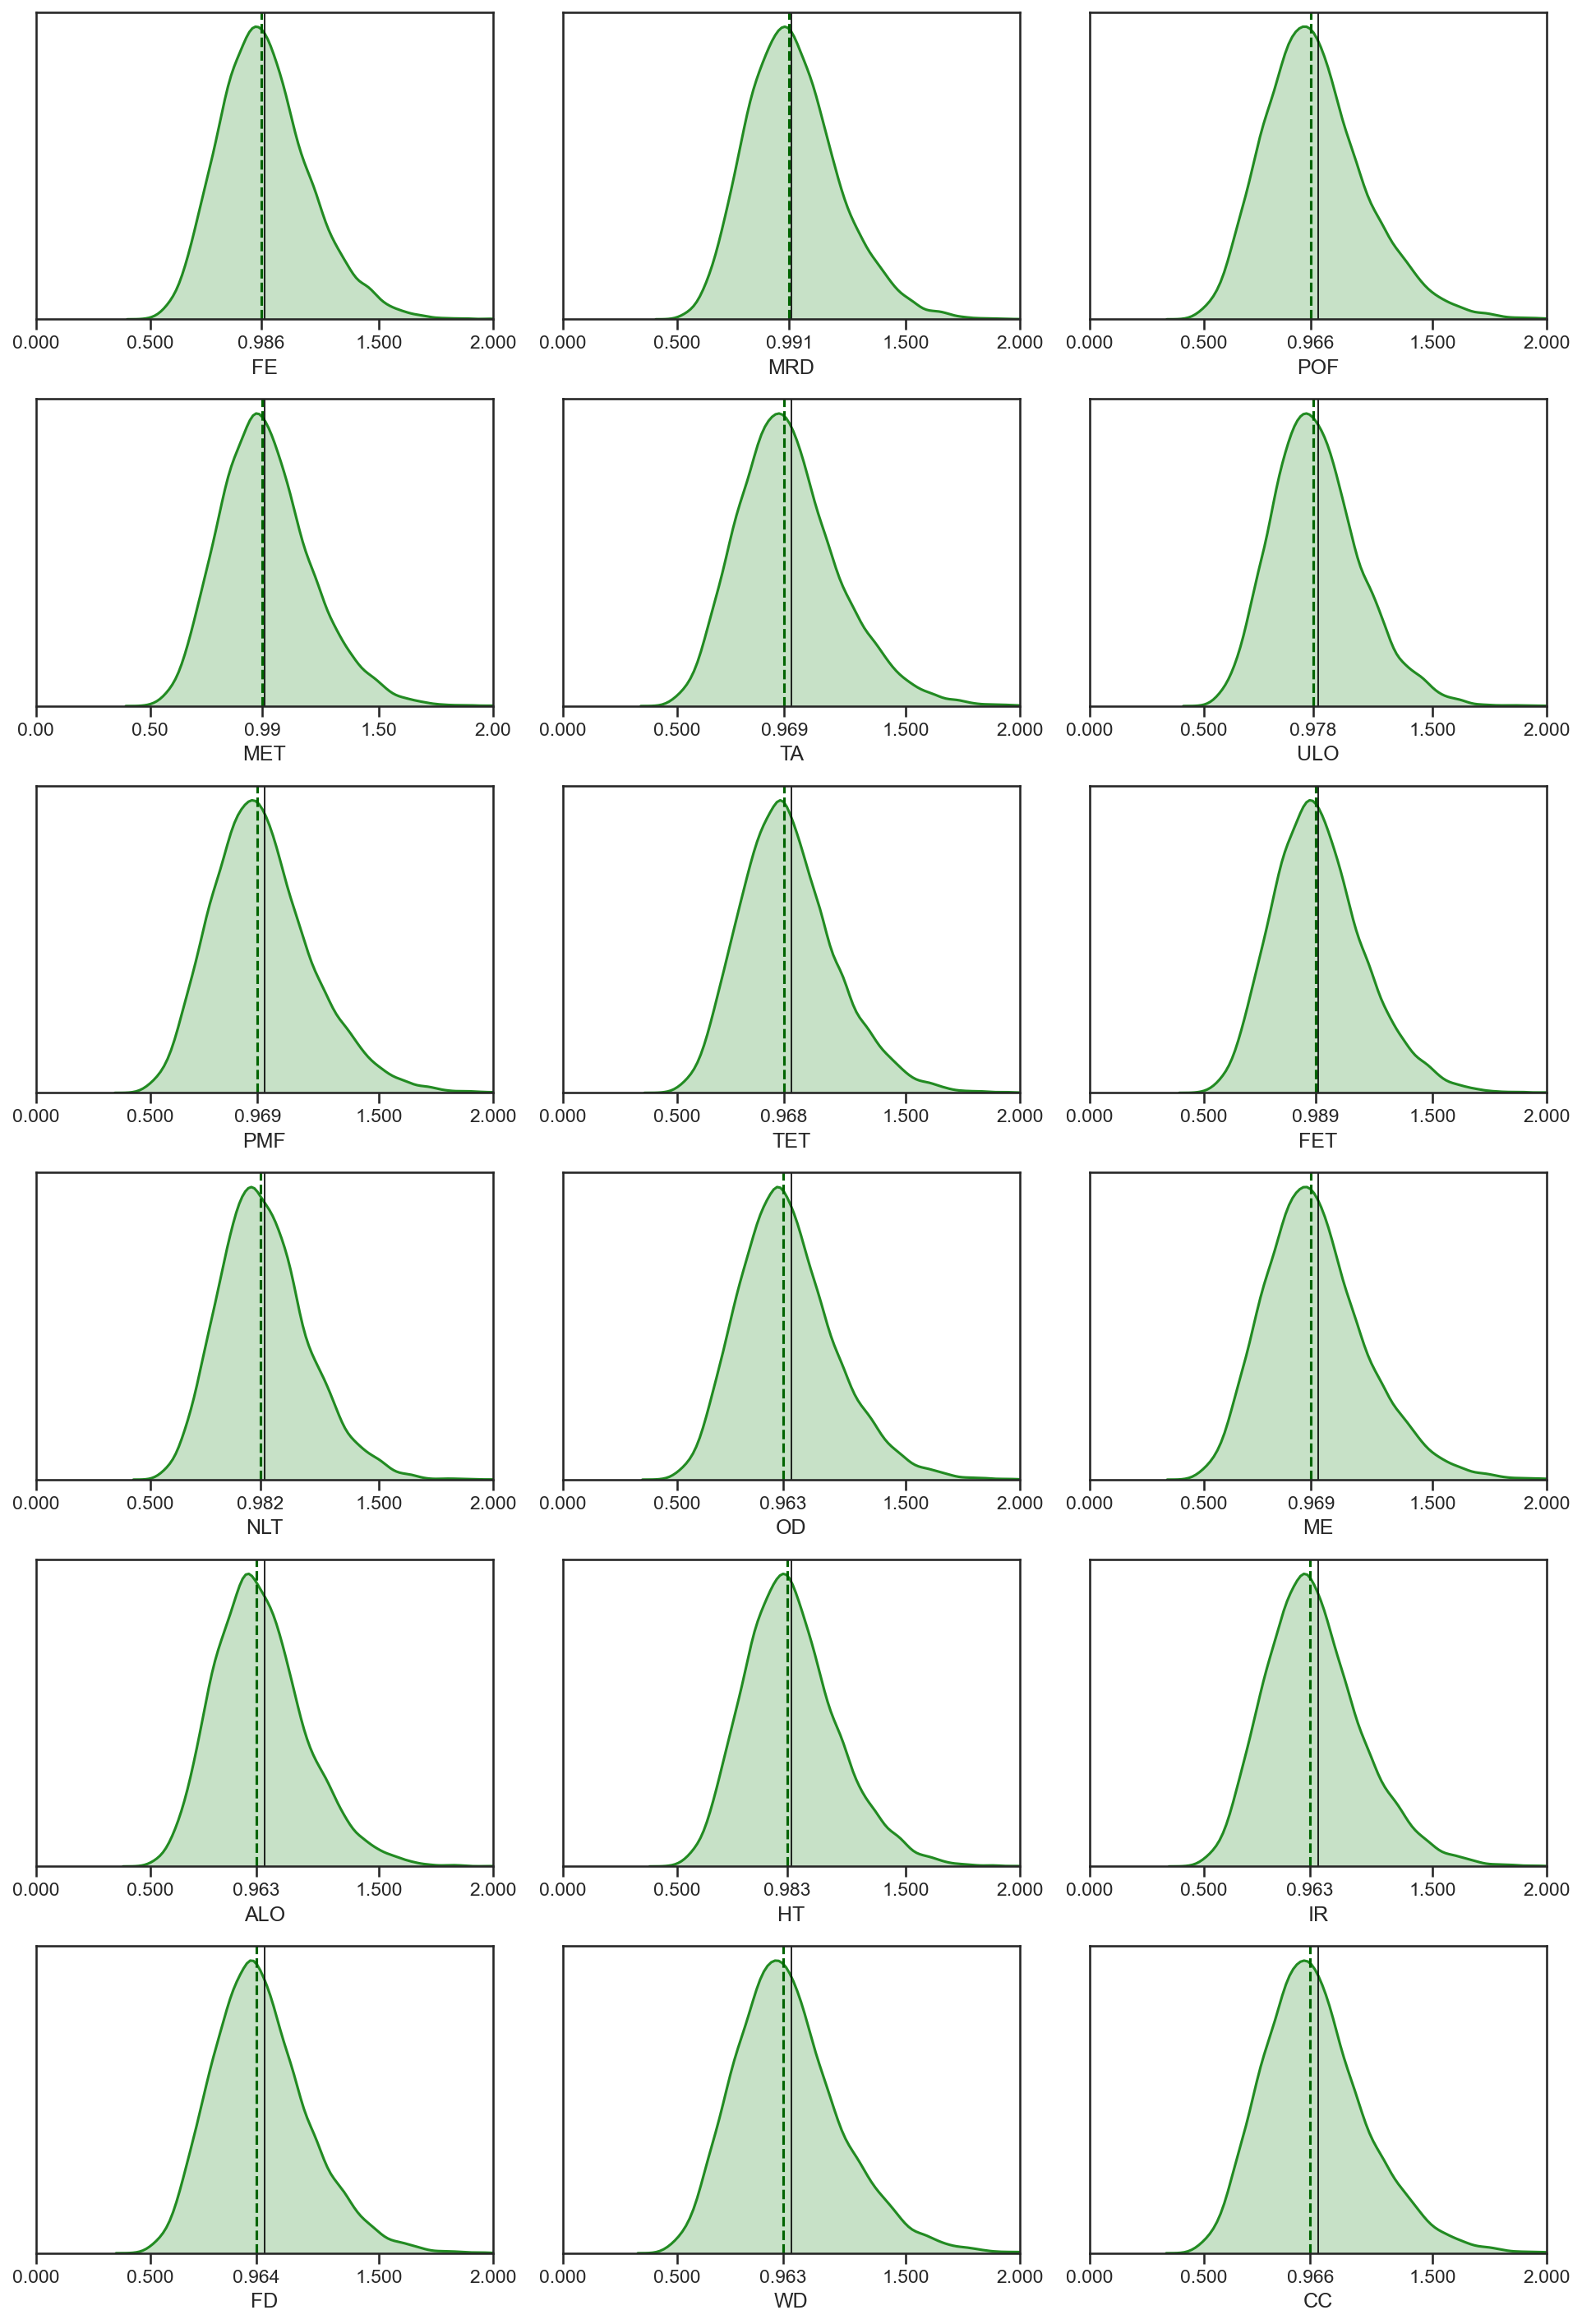

In [5]:
echo.dist_compare(bravo, pathway='MP', save=False)

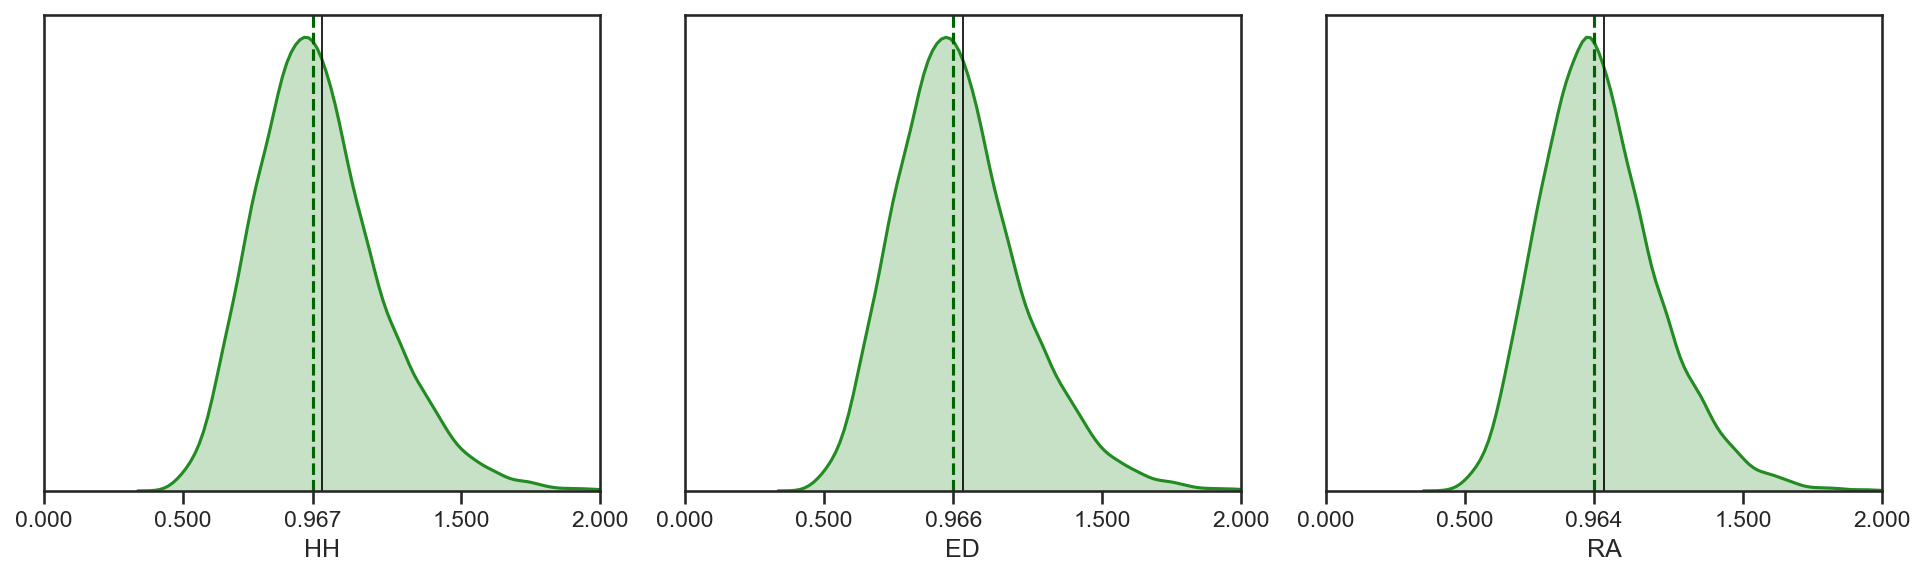

In [6]:
echo.dist_compare(bravo, pathway='EP', save=True)